**Task: Create FPR/FNR/Accuracy graphs for different mixing rates for the Folktable**


Custom Prediction Task: ACSIncomeNew : Income greater the $50k on target SEX from ACS 2018 Data for CA

**CA 2018, 2015, 2017**

CA 2018

CA 2018 Data
Fixed training set size:  9200
Original training set size: 195665
Original number of females in train set: 92354
Percentage of total females that's being currently graphed: 9.961669229269983%


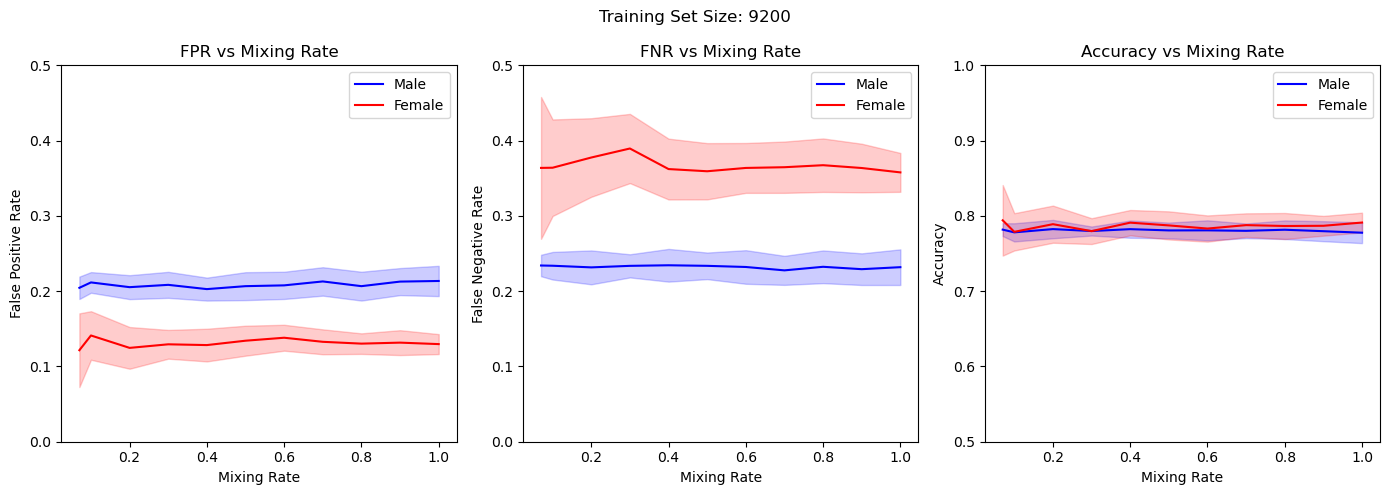

Fixed training set size:  27700
Original training set size: 195665
Original number of females in train set: 92354
Percentage of total females that's being currently graphed: 29.993286701171577%


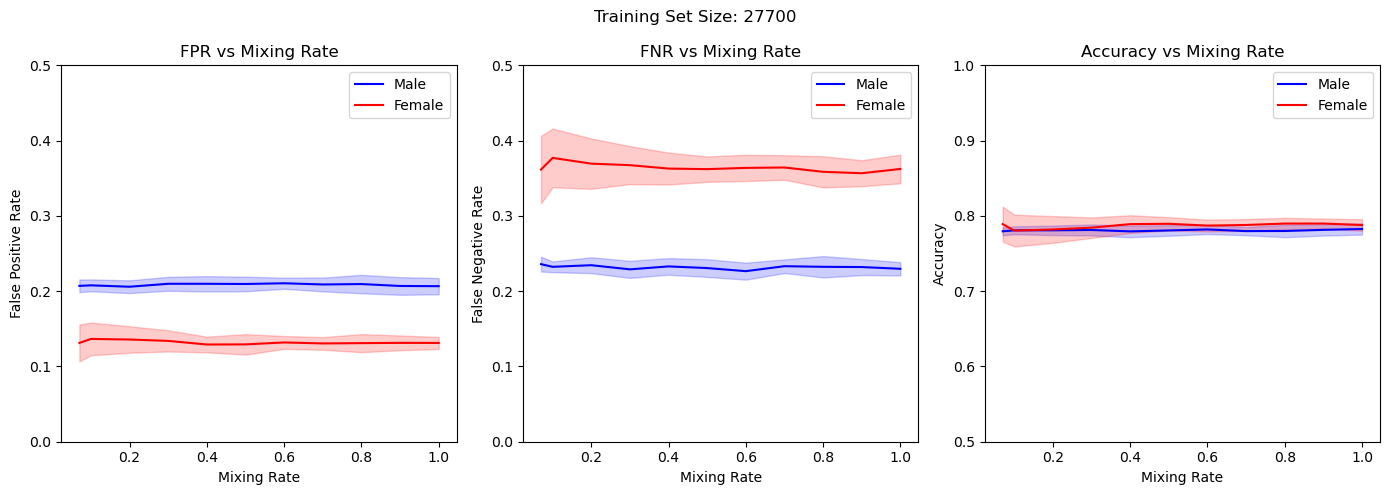

Fixed training set size:  46200
Original training set size: 195665
Original number of females in train set: 92354
Percentage of total females that's being currently graphed: 50.02490417307317%


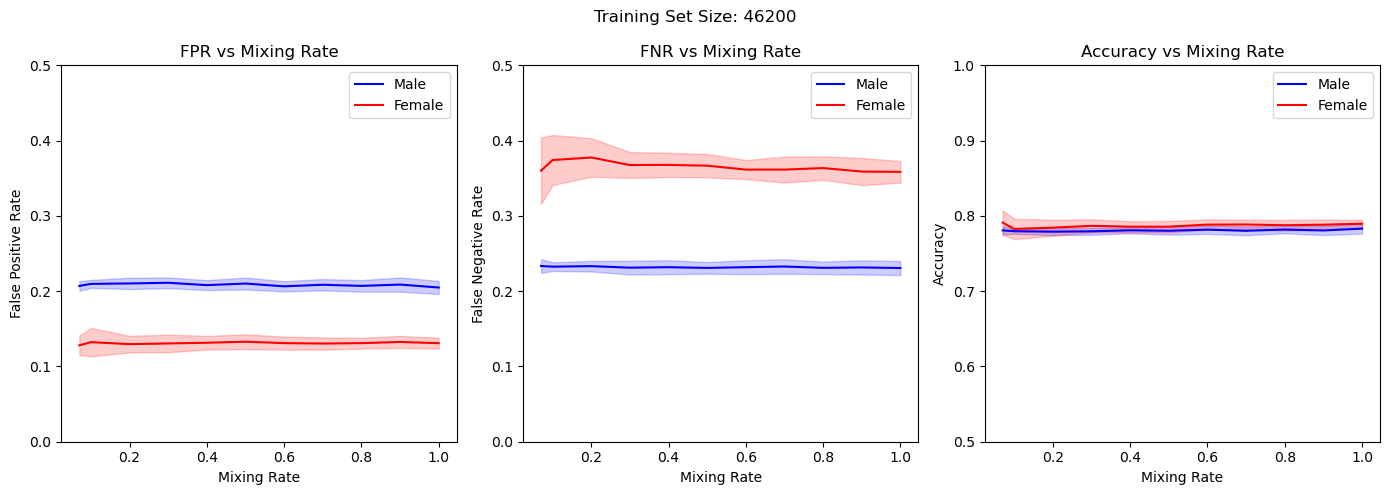

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import folktables
from folktables import ACSDataSource

def fetch_data_for_state_year(state, year):
    data_source = ACSDataSource(survey_year=year, horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True)
    features, label, group = ACSIncomeNew.df_to_numpy(acs_data)
    return features, label, group

def calculate_metrics(y_true, y_pred):
    # Check if the confusion matrix is empty
    if np.sum(y_true == 1) == 0 or np.sum(y_true == 0) == 0:
        fpr, fnr, acc = np.nan, np.nan, np.nan
    else:
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Extract values from the confusion matrix
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        acc = accuracy_score(y_true, y_pred)
    return fpr, fnr, acc

ACSIncomeAllFeatures = folktables.BasicProblem(
    features=[
        'AGEP', # Age (1-99)\n",
        'COW', # Class of Worker (1-9)\n",
        'SCHL', # Education (1-24)\n",
        'MAR', # Marital status (1-5)\n",
        'OCCP', # Occupation 0000-9920\n",
        'POBP', # Place of birth 000-554\n",
        'RELP', ## Relationship (00-17)\n",
        'WKHP',# Hours worked per week (0-99)\n",
        'SEX', # sex (1,2)\n",
        'RAC1P', # race (1-9)\n",
        # Original ACSIncomeFeatures
        'DIVISION', # Division code based on 2010 Census definitions
        'PUMA', # Public use microdata area code, population >100k
        'REGION', # Region code
        'ST', # State code
        'ADHHSG', # Adjustment factor for housing dollar amounts
        'ADJINC', # Adjustment factor for income and earnings dollar amounts
        'WGTP', # Housing Unit Weight
        'NP', # Number of persons in this household
        'ACCESS', # Access to the Internet
        'ACR', # Lot size (number of acres for house)
        'BDSP', # Number of bedrooms
        'BROADBND', # Cellular data plan for smartphone or other mobile device
        'COMPOTHX', # Other computer equipment
        'CONP', # Condo fee
        'DIALUP', # Dialup service
        'ELEFP',
        
        
    
        
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)


ACSIncomeNew = folktables.BasicProblem(
    features=[
        'AGEP', # Age (1-99)\n",
        'COW', # Class of Worker (1-9)\n",
        'SCHL', # Education (1-24)\n",
        'MAR', # Marital status (1-5)\n",
        'OCCP', # Occupation 0000-9920\n",
        'POBP', # Place of birth 000-554\n",
        'RELP', ## Relationship (00-17)\n",
        'WKHP',# Hours worked per week (0-99)\n",
        'SEX', # sex (1,2)\n",
        'RAC1P', # race (1-9)\n",
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)



# Evaluation function for different mixing rates and modified sizes

# Mixing rate is determined by multiplying total number of original females by mixing rate, then 
def evaluate_model_with_mixing_rate_and_size(mixing_rate, modified_size, features, labels, groups):
    initial_size = len(features)
    num_males_original = np.sum(groups == 1)
    num_females_original = np.sum(groups == 2)

    female_indices = np.where(groups == 2)[0]
    num_female_to_keep = int(len(female_indices) * mixing_rate)
    subsampled_female_indices = np.random.choice(female_indices, size=num_female_to_keep, replace=False)

    modified_features = np.concatenate([features[groups == 1], features[subsampled_female_indices]])
    modified_labels = np.concatenate([labels[groups == 1], labels[subsampled_female_indices]])
    modified_groups = np.concatenate([groups[groups == 1], groups[subsampled_female_indices]])

    if modified_size is not None and modified_size < len(modified_features):
        subsample_indices = np.random.choice(np.arange(len(modified_features)), size=modified_size, replace=False)
        modified_features = modified_features[subsample_indices]
        modified_labels = modified_labels[subsample_indices]
        modified_groups = modified_groups[subsample_indices]

    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        modified_features, modified_labels, modified_groups, test_size=0.2, random_state=0)

    model = make_pipeline(StandardScaler(), LogisticRegression())
#     model = make_pipeline(StandardScaler(),  RandomForestClassifier(max_depth=16, min_samples_leaf=3))
#     model = RandomForestClassifier()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    fpr_male, fnr_male, acc_male = calculate_metrics(y_test[group_test == 1], y_pred[group_test == 1])
    fpr_female, fnr_female, acc_female = calculate_metrics(y_test[group_test == 2], y_pred[group_test == 2])

    return initial_size, modified_size, num_males_original, num_females_original, len(modified_features), \
           fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female

# Fetch data for California
ca_features, ca_label, ca_group = fetch_data_for_state_year('CA', '2018')

mixing_rates = [0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Total females in the dataset
total_females = len(np.where(ca_group == 2)[0])

print( "CA 2018 Data")

# Iterate over different fixed training set sizes
fixed_train_sizes = [int(round(0.1 * total_females, -2)), int(round(0.3 * total_females, -2)), int(round(0.5 * total_females, -2))]
for fixed_train_size in fixed_train_sizes:
    fixed_train_size 
    print("Fixed training set size: ", fixed_train_size)

    results_subset_list = []
    num_iterations = 30
    for _ in range(num_iterations):
        results_subset = {'Mixing Rate': [], 'FPR Male': [], 'FNR Male': [], 'Accuracy Male': [],
                          'FPR Female': [], 'FNR Female': [], 'Accuracy Female': []}
        for mixing_rate in mixing_rates:
            initial_size, modified_size, num_males_original, num_females_original, len_modified_features, fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female = evaluate_model_with_mixing_rate_and_size(mixing_rate, fixed_train_size, ca_features, ca_label, ca_group)

            results_subset['Mixing Rate'].append(mixing_rate)
            results_subset['FPR Male'].append(fpr_male)
            results_subset['FNR Male'].append(fnr_male)
            results_subset['Accuracy Male'].append(acc_male)
            results_subset['FPR Female'].append(fpr_female)
            results_subset['FNR Female'].append(fnr_female)
            results_subset['Accuracy Female'].append(acc_female)

        results_subset_list.append(results_subset)

    average_results_subset = {'Mixing Rate': mixing_rates,
                              'FPR Male': np.mean([result['FPR Male'] for result in results_subset_list], axis=0),
                              'FNR Male': np.mean([result['FNR Male'] for result in results_subset_list], axis=0),
                                      'Accuracy Male': np.mean([result['Accuracy Male'] for result in results_subset_list], axis=0),
                              'FPR Female': np.mean([result['FPR Female'] for result in results_subset_list], axis=0),
                              'FNR Female': np.mean([result['FNR Female'] for result in results_subset_list], axis=0),
                              'Accuracy Female': np.mean([result['Accuracy Female'] for result in results_subset_list], axis=0)}

    average_results_subset_df = pd.DataFrame(average_results_subset)

    std_results_subset = {'FPR Male': np.std([result['FPR Male'] for result in results_subset_list], axis=0),
                          'FNR Male': np.std([result['FNR Male'] for result in results_subset_list], axis=0),
                          'Accuracy Male': np.std([result['Accuracy Male'] for result in results_subset_list], axis=0),
                          'FPR Female': np.std([result['FPR Female'] for result in results_subset_list], axis=0),
                          'FNR Female': np.std([result['FNR Female'] for result in results_subset_list], axis=0),
                          'Accuracy Female': np.std([result['Accuracy Female'] for result in results_subset_list], axis=0)}
    
#     print(f"Original training set size: {len(initial_size)}")
    print(f"Original training set size: {initial_size}")

#     print(f"Original number of females in train set: {np.sum(group_train == 2)}")
    print(f"Original number of females in train set: {num_females_original}")

    print(f"Percentage of total females that's being currently graphed: {fixed_train_size / total_females * 100}%")


    fig, axs = plt.subplots(1, 3, figsize=(14, 5))
    plt.title('CA 2018: ACSIncome MALE / FEMALE')
    fig.suptitle(f'Training Set Size: {fixed_train_size}')

    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Male'], label='Male', color='blue')
    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Female'], label='Female', color='red')
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Male'] - std_results_subset['FPR Male'],
                       average_results_subset_df['FPR Male'] + std_results_subset['FPR Male'],
                       color='blue', alpha=0.2)
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Female'] - std_results_subset['FPR Female'],
                       average_results_subset_df['FPR Female'] + std_results_subset['FPR Female'],
                       color='red', alpha=0.2)
    axs[0].set_xlabel('Mixing Rate')
    axs[0].set_ylabel('False Positive Rate')
    axs[0].set_title('FPR vs Mixing Rate')
    axs[0].legend()
    axs[0].set_ylim(0, 0.5)

    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Male'], label='Male', color='blue')
    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Female'], label='Female', color='red')
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Male'] - std_results_subset['FNR Male'],
                       average_results_subset_df['FNR Male'] + std_results_subset['FNR Male'],
                       color='blue', alpha=0.2)
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Female'] - std_results_subset['FNR Female'],
                       average_results_subset_df['FNR Female'] + std_results_subset['FNR Female'],
                       color='red', alpha=0.2)
    axs[1].set_xlabel('Mixing Rate')
    axs[1].set_ylabel('False Negative Rate')
    axs[1].set_title('FNR vs Mixing Rate')
    axs[1].legend()
    axs[1].set_ylim(0, 0.5)

    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Male'], label='Male', color='blue')
    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Female'], label='Female', color='red')
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Male'] - std_results_subset['Accuracy Male'],
                       average_results_subset_df['Accuracy Male'] + std_results_subset['Accuracy Male'],
                       color='blue', alpha=0.2)
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Female'] - std_results_subset['Accuracy Female'],
                       average_results_subset_df['Accuracy Female'] + std_results_subset['Accuracy Female'],
                       color='red', alpha=0.2)
    axs[2].set_xlabel('Mixing Rate')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_title('Accuracy vs Mixing Rate')
    axs[2].legend()
    axs[2].set_ylim(0.5, 1.0)

    plt.tight_layout()
    plt.show()


CA 2015

Fixed training set size:  8800
Original training set size: 131232
Original number of females in train set: 61668
Percentage of total females that's being currently graphed: 10.004888752458587%


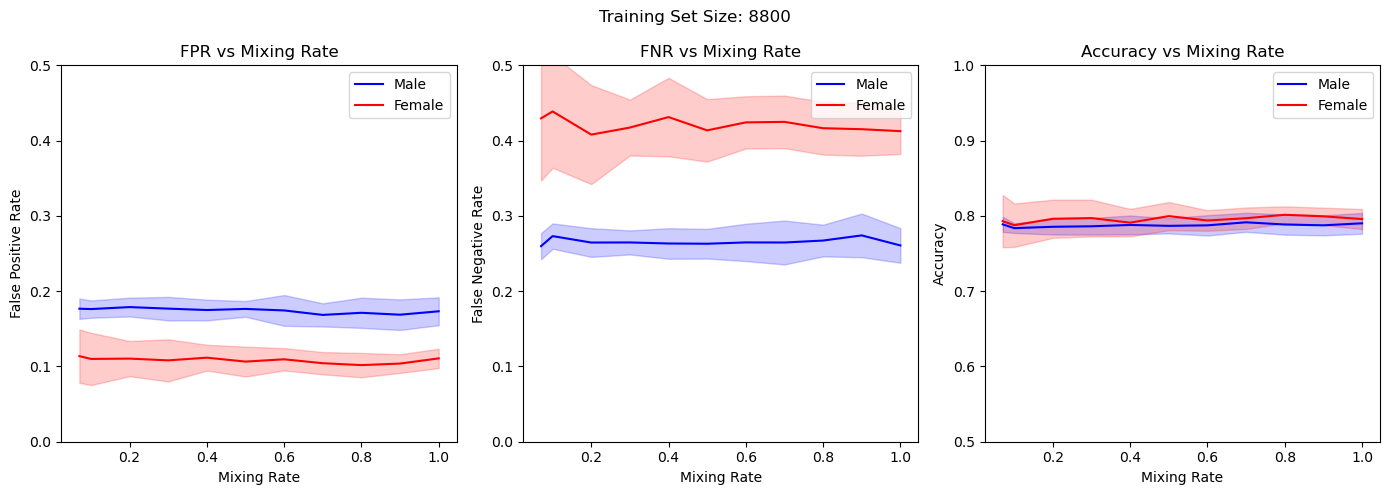

Fixed training set size:  26400
Original training set size: 131232
Original number of females in train set: 61668
Percentage of total females that's being currently graphed: 30.01466625737576%


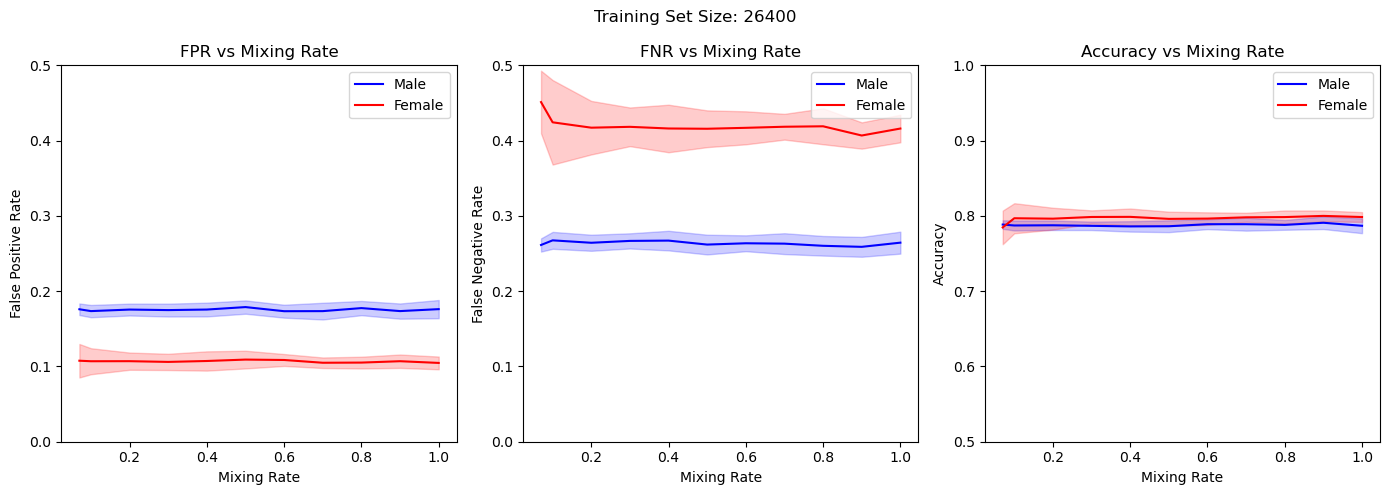

Fixed training set size:  44000
Original training set size: 131232
Original number of females in train set: 61668
Percentage of total females that's being currently graphed: 50.02444376229293%


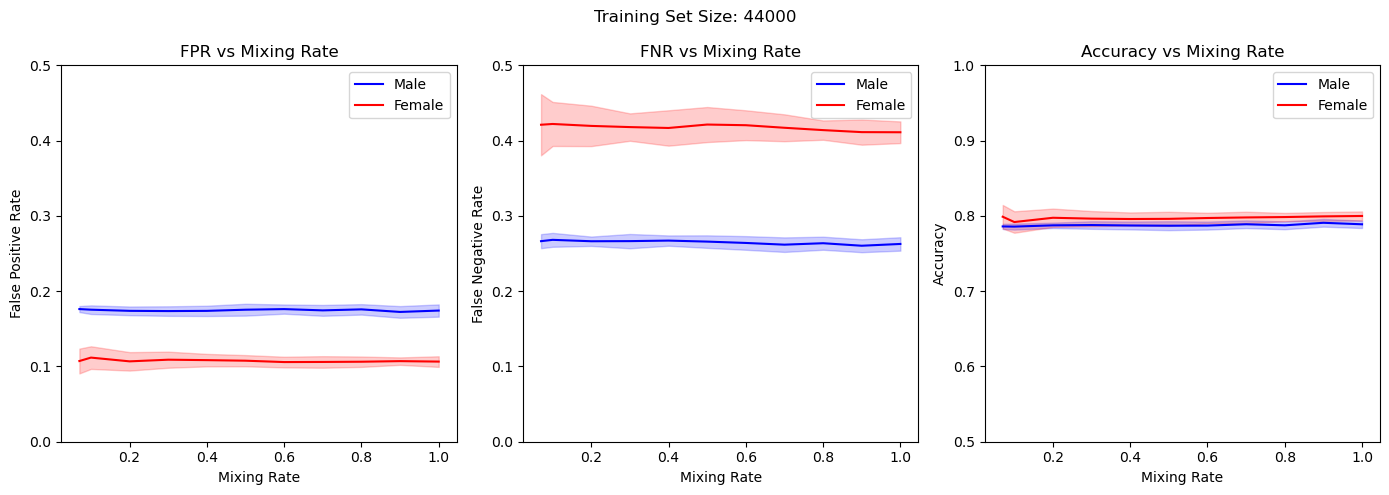

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import folktables
from folktables import ACSDataSource

def fetch_data_for_state(state):
    data_source = ACSDataSource(survey_year='2015', horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True)
    features, label, group = ACSIncomeNew.df_to_numpy(acs_data)
    return features, label, group

def calculate_metrics(y_true, y_pred):
    # Check if the confusion matrix is empty
    if np.sum(y_true == 1) == 0 or np.sum(y_true == 0) == 0:
        fpr, fnr, acc = np.nan, np.nan, np.nan
    else:
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Extract values from the confusion matrix
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        acc = accuracy_score(y_true, y_pred)
    return fpr, fnr, acc

ACSIncomeNew = folktables.BasicProblem(
    features=[
        'AGEP', # Age (1-99)\n",
        'COW', # Class of Worker (1-9)\n",
        'SCHL', # Education (1-24)\n",
        'MAR', # Marital status (1-5)\n",
        'OCCP', # Occupation 0000-9920\n",
        'POBP', # Place of birth 000-554\n",
        'RELP', ## Relationship (00-17)\n",
        'WKHP',# Hours worked per week (0-99)\n",
        'SEX', # sex (1,2)\n",
        'RAC1P', # race (1-9)\n",
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)



# Evaluation function for different mixing rates and modified sizes
def evaluate_model_with_mixing_rate_and_size(mixing_rate, modified_size, features, labels, groups):
    initial_size = len(features)
    num_males_original = np.sum(groups == 1)
    num_females_original = np.sum(groups == 2)

    female_indices = np.where(groups == 2)[0]
    num_female_to_keep = int(len(female_indices) * mixing_rate)
    subsampled_female_indices = np.random.choice(female_indices, size=num_female_to_keep, replace=False)

    modified_features = np.concatenate([features[groups == 1], features[subsampled_female_indices]])
    modified_labels = np.concatenate([labels[groups == 1], labels[subsampled_female_indices]])
    modified_groups = np.concatenate([groups[groups == 1], groups[subsampled_female_indices]])

    if modified_size is not None and modified_size < len(modified_features):
        subsample_indices = np.random.choice(np.arange(len(modified_features)), size=modified_size, replace=False)
        modified_features = modified_features[subsample_indices]
        modified_labels = modified_labels[subsample_indices]
        modified_groups = modified_groups[subsample_indices]

    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        modified_features, modified_labels, modified_groups, test_size=0.2, random_state=0)

    model = make_pipeline(StandardScaler(), LogisticRegression())
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    fpr_male, fnr_male, acc_male = calculate_metrics(y_test[group_test == 1], y_pred[group_test == 1])
    fpr_female, fnr_female, acc_female = calculate_metrics(y_test[group_test == 2], y_pred[group_test == 2])

    return initial_size, modified_size, num_males_original, num_females_original, len(modified_features), \
           fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female

# Fetch data for California
ca_features, ca_label, ca_group = fetch_data_for_state('CA')

# Split data for training
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    ca_features, ca_label, ca_group, test_size=0.3, random_state=0)

# Train the model
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

mixing_rates = [0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Total females in the dataset
total_females = len(np.where(ca_group == 2)[0])

print("CA 2015 Data")

# Iterate over different fixed training set sizes
fixed_train_sizes = [int(round(0.1 * total_females, -2)), int(round(0.3 * total_females, -2)), int(round(0.5 * total_females, -2))]
for fixed_train_size in fixed_train_sizes:
    print("Fixed training set size: ", fixed_train_size)

    results_subset_list = []
    num_iterations = 30
    for _ in range(num_iterations):
        results_subset = {'Mixing Rate': [], 'FPR Male': [], 'FNR Male': [], 'Accuracy Male': [],
                          'FPR Female': [], 'FNR Female': [], 'Accuracy Female': []}
        for mixing_rate in mixing_rates:
            initial_size, _, num_males_original, num_females_original, _, \
            fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female = evaluate_model_with_mixing_rate_and_size(mixing_rate, fixed_train_size, ca_features, ca_label, ca_group)

            results_subset['Mixing Rate'].append(mixing_rate)
            results_subset['FPR Male'].append(fpr_male)
            results_subset['FNR Male'].append(fnr_male)
            results_subset['Accuracy Male'].append(acc_male)
            results_subset['FPR Female'].append(fpr_female)
            results_subset['FNR Female'].append(fnr_female)
            results_subset['Accuracy Female'].append(acc_female)

        results_subset_list.append(results_subset)

    average_results_subset = {'Mixing Rate': mixing_rates,
                              'FPR Male': np.mean([result['FPR Male'] for result in results_subset_list], axis=0),
                              'FNR Male': np.mean([result['FNR Male'] for result in results_subset_list], axis=0),
                              'Accuracy Male': np.mean([result['Accuracy Male'] for result in results_subset_list], axis=0),
                              'FPR Female': np.mean([result['FPR Female'] for result in results_subset_list], axis=0),
                              'FNR Female': np.mean([result['FNR Female'] for result in results_subset_list], axis=0),
                              'Accuracy Female': np.mean([result['Accuracy Female'] for result in results_subset_list], axis=0)}

    average_results_subset_df = pd.DataFrame(average_results_subset)

    std_results_subset = {'FPR Male': np.std([result['FPR Male'] for result in results_subset_list], axis=0),
                          'FNR Male': np.std([result['FNR Male'] for result in results_subset_list], axis=0),
                          'Accuracy Male': np.std([result['Accuracy Male'] for result in results_subset_list], axis=0),
                          'FPR Female': np.std([result['FPR Female'] for result in results_subset_list], axis=0),
                          'FNR Female': np.std([result['FNR Female'] for result in results_subset_list], axis=0),
                          'Accuracy Female': np.std([result['Accuracy Female'] for result in results_subset_list], axis=0)}
    
    print(f"Original training set size: {len(X_train)}")
    print(f"Original number of females in train set: {np.sum(group_train == 2)}")
    print(f"Percentage of total females that's being currently graphed: {fixed_train_size / total_females * 100}%")


    fig, axs = plt.subplots(1, 3, figsize=(14, 5))
    plt.title('CA 2018: ACSIncome MALE / FEMALE')
    fig.suptitle(f'Training Set Size: {fixed_train_size}')

    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Male'], label='Male', color='blue')
    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Female'], label='Female', color='red')
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Male'] - std_results_subset['FPR Male'],
                       average_results_subset_df['FPR Male'] + std_results_subset['FPR Male'],
                       color='blue', alpha=0.2)
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Female'] - std_results_subset['FPR Female'],
                       average_results_subset_df['FPR Female'] + std_results_subset['FPR Female'],
                       color='red', alpha=0.2)
    axs[0].set_xlabel('Mixing Rate')
    axs[0].set_ylabel('False Positive Rate')
    axs[0].set_title('FPR vs Mixing Rate')
    axs[0].legend()
    axs[0].set_ylim(0, 0.5)

    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Male'], label='Male', color='blue')
    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Female'], label='Female', color='red')
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Male'] - std_results_subset['FNR Male'],
                       average_results_subset_df['FNR Male'] + std_results_subset['FNR Male'],
                       color='blue', alpha=0.2)
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Female'] - std_results_subset['FNR Female'],
                       average_results_subset_df['FNR Female'] + std_results_subset['FNR Female'],
                       color='red', alpha=0.2)
    axs[1].set_xlabel('Mixing Rate')
    axs[1].set_ylabel('False Negative Rate')
    axs[1].set_title('FNR vs Mixing Rate')
    axs[1].legend()
    axs[1].set_ylim(0, 0.5)

    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Male'], label='Male', color='blue')
    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Female'], label='Female', color='red')
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Male'] - std_results_subset['Accuracy Male'],
                       average_results_subset_df['Accuracy Male'] + std_results_subset['Accuracy Male'],
                       color='blue', alpha=0.2)
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Female'] - std_results_subset['Accuracy Female'],
                       average_results_subset_df['Accuracy Female'] + std_results_subset['Accuracy Female'],
                       color='red', alpha=0.2)
    axs[2].set_xlabel('Mixing Rate')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_title('Accuracy vs Mixing Rate')
    axs[2].legend()
    axs[2].set_ylim(0.5, 1.0)

    plt.tight_layout()
    plt.show()


CA 2017

Fixed training set size:  9000
Original training set size: 135050
Original number of females in train set: 63200
Percentage of total females that's being currently graphed: 9.956853634251576%


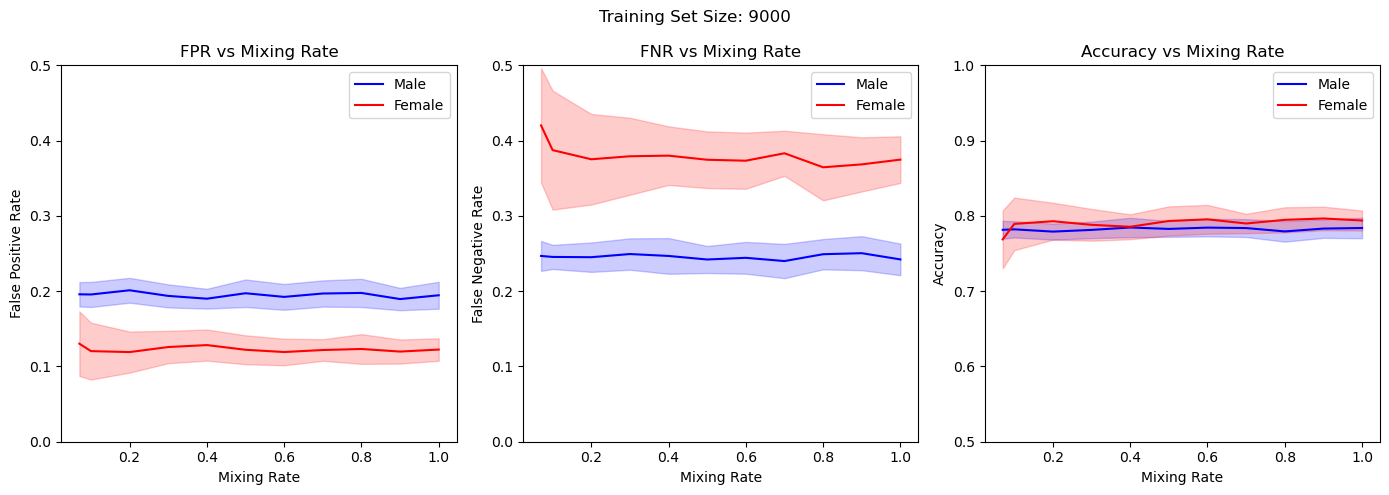

Fixed training set size:  27100
Original training set size: 135050
Original number of females in train set: 63200
Percentage of total females that's being currently graphed: 29.981192609801973%


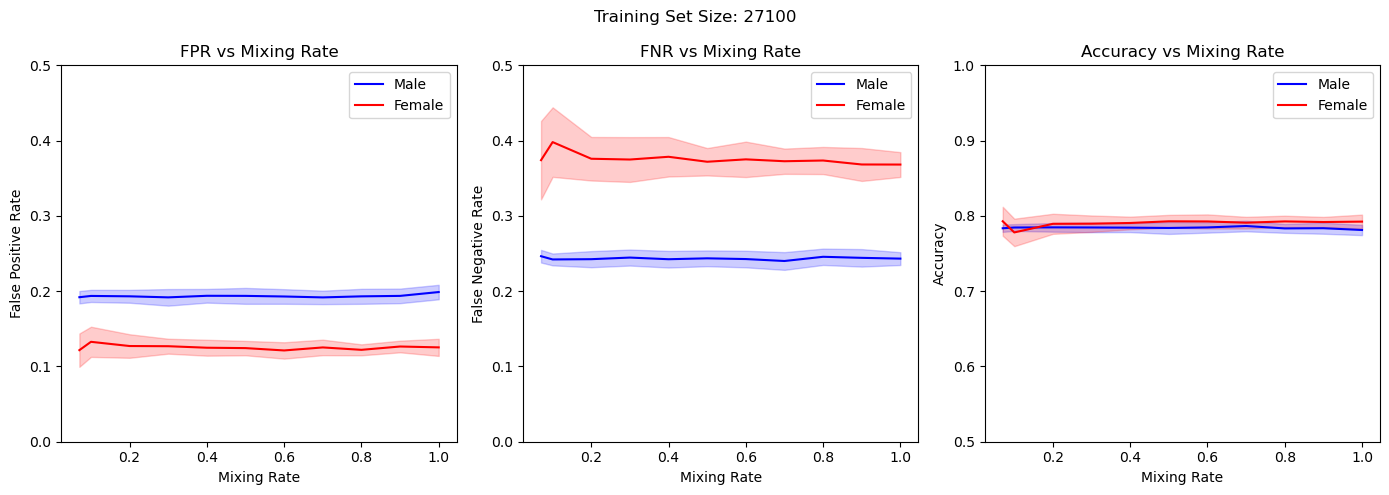

Fixed training set size:  45200
Original training set size: 135050
Original number of females in train set: 63200
Percentage of total females that's being currently graphed: 50.00553158535236%


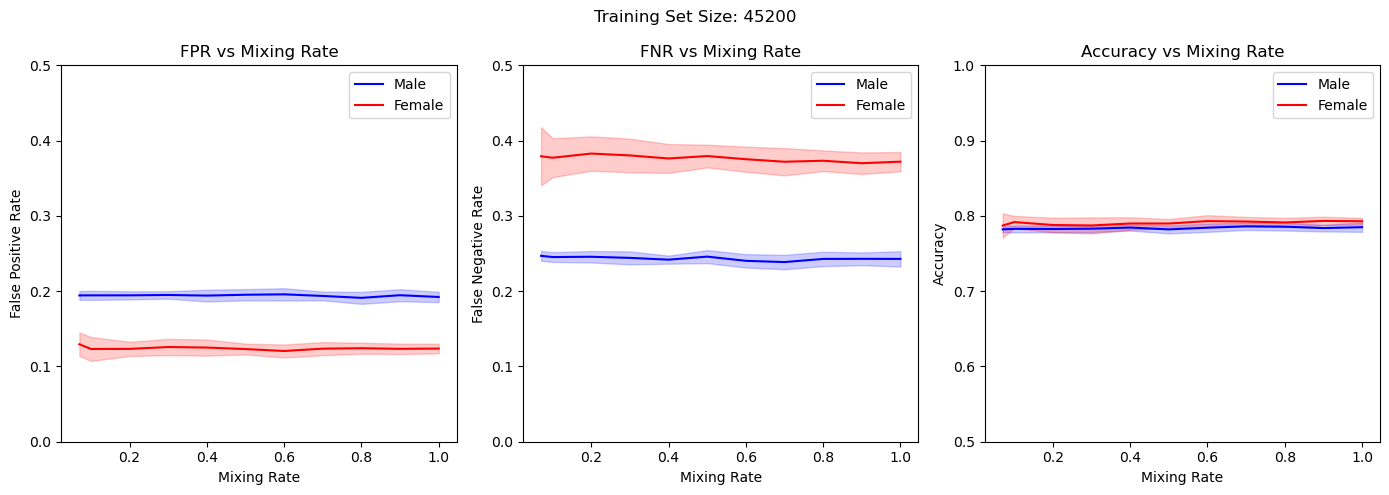

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import folktables
from folktables import ACSDataSource

def fetch_data_for_state(state):
    data_source = ACSDataSource(survey_year='2017', horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True)
    features, label, group = ACSIncomeNew.df_to_numpy(acs_data)
    return features, label, group

def calculate_metrics(y_true, y_pred):
    # Check if the confusion matrix is empty
    if np.sum(y_true == 1) == 0 or np.sum(y_true == 0) == 0:
        fpr, fnr, acc = np.nan, np.nan, np.nan
    else:
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Extract values from the confusion matrix
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        acc = accuracy_score(y_true, y_pred)
    return fpr, fnr, acc

ACSIncomeNew = folktables.BasicProblem(
    features=[
        'AGEP', # Age (1-99)\n",
        'COW', # Class of Worker (1-9)\n",
        'SCHL', # Education (1-24)\n",
        'MAR', # Marital status (1-5)\n",
        'OCCP', # Occupation 0000-9920\n",
        'POBP', # Place of birth 000-554\n",
        'RELP', ## Relationship (00-17)\n",
        'WKHP',# Hours worked per week (0-99)\n",
        'SEX', # sex (1,2)\n",
        'RAC1P', # race (1-9)\n",
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)



# Evaluation function for different mixing rates and modified sizes
def evaluate_model_with_mixing_rate_and_size(mixing_rate, modified_size, features, labels, groups):
    initial_size = len(features)
    num_males_original = np.sum(groups == 1)
    num_females_original = np.sum(groups == 2)

    female_indices = np.where(groups == 2)[0]
    num_female_to_keep = int(len(female_indices) * mixing_rate)
    subsampled_female_indices = np.random.choice(female_indices, size=num_female_to_keep, replace=False)

    modified_features = np.concatenate([features[groups == 1], features[subsampled_female_indices]])
    modified_labels = np.concatenate([labels[groups == 1], labels[subsampled_female_indices]])
    modified_groups = np.concatenate([groups[groups == 1], groups[subsampled_female_indices]])

    if modified_size is not None and modified_size < len(modified_features):
        subsample_indices = np.random.choice(np.arange(len(modified_features)), size=modified_size, replace=False)
        modified_features = modified_features[subsample_indices]
        modified_labels = modified_labels[subsample_indices]
        modified_groups = modified_groups[subsample_indices]

    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        modified_features, modified_labels, modified_groups, test_size=0.2, random_state=0)

    model = make_pipeline(StandardScaler(), LogisticRegression())
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    fpr_male, fnr_male, acc_male = calculate_metrics(y_test[group_test == 1], y_pred[group_test == 1])
    fpr_female, fnr_female, acc_female = calculate_metrics(y_test[group_test == 2], y_pred[group_test == 2])

    return initial_size, modified_size, num_males_original, num_females_original, len(modified_features), \
           fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female

# Fetch data for California
ca_features, ca_label, ca_group = fetch_data_for_state('CA')

# Split data for training
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    ca_features, ca_label, ca_group, test_size=0.3, random_state=0)

# Train the model
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

mixing_rates = [0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Total females in the dataset
total_females = len(np.where(ca_group == 2)[0])

print("CA 2017 Data")

# Iterate over different fixed training set sizes
fixed_train_sizes = [int(round(0.1 * total_females, -2)), int(round(0.3 * total_females, -2)), int(round(0.5 * total_females, -2))]
for fixed_train_size in fixed_train_sizes:
    print("Fixed training set size: ", fixed_train_size)

    results_subset_list = []
    num_iterations = 30
    for _ in range(num_iterations):
        results_subset = {'Mixing Rate': [], 'FPR Male': [], 'FNR Male': [], 'Accuracy Male': [],
                          'FPR Female': [], 'FNR Female': [], 'Accuracy Female': []}
        for mixing_rate in mixing_rates:
            initial_size, _, num_males_original, num_females_original, _, \
            fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female = \
            evaluate_model_with_mixing_rate_and_size(mixing_rate, fixed_train_size, ca_features, ca_label, ca_group)

            results_subset['Mixing Rate'].append(mixing_rate)
            results_subset['FPR Male'].append(fpr_male)
            results_subset['FNR Male'].append(fnr_male)
            results_subset['Accuracy Male'].append(acc_male)
            results_subset['FPR Female'].append(fpr_female)
            results_subset['FNR Female'].append(fnr_female)
            results_subset['Accuracy Female'].append(acc_female)

        results_subset_list.append(results_subset)

    average_results_subset = {'Mixing Rate': mixing_rates,
                              'FPR Male': np.mean([result['FPR Male'] for result in results_subset_list], axis=0),
                              'FNR Male': np.mean([result['FNR Male'] for result in results_subset_list], axis=0),
                              'Accuracy Male': np.mean([result['Accuracy Male'] for result in results_subset_list], axis=0),
                              'FPR Female': np.mean([result['FPR Female'] for result in results_subset_list], axis=0),
                              'FNR Female': np.mean([result['FNR Female'] for result in results_subset_list], axis=0),
                              'Accuracy Female': np.mean([result['Accuracy Female'] for result in results_subset_list], axis=0)}

    average_results_subset_df = pd.DataFrame(average_results_subset)

    std_results_subset = {'FPR Male': np.std([result['FPR Male'] for result in results_subset_list], axis=0),
                          'FNR Male': np.std([result['FNR Male'] for result in results_subset_list], axis=0),
                          'Accuracy Male': np.std([result['Accuracy Male'] for result in results_subset_list], axis=0),
                          'FPR Female': np.std([result['FPR Female'] for result in results_subset_list], axis=0),
                          'FNR Female': np.std([result['FNR Female'] for result in results_subset_list], axis=0),
                          'Accuracy Female': np.std([result['Accuracy Female'] for result in results_subset_list], axis=0)}
    
    print(f"Original training set size: {len(X_train)}")
    print(f"Original number of females in train set: {np.sum(group_train == 2)}")
    print(f"Percentage of total females that's being currently graphed: {fixed_train_size / total_females * 100}%")


    fig, axs = plt.subplots(1, 3, figsize=(14, 5))
    plt.title('CA 2018: ACSIncome MALE / FEMALE')
    fig.suptitle(f'Training Set Size: {fixed_train_size}')

    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Male'], label='Male', color='blue')
    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Female'], label='Female', color='red')
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Male'] - std_results_subset['FPR Male'],
                       average_results_subset_df['FPR Male'] + std_results_subset['FPR Male'],
                       color='blue', alpha=0.2)
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Female'] - std_results_subset['FPR Female'],
                       average_results_subset_df['FPR Female'] + std_results_subset['FPR Female'],
                       color='red', alpha=0.2)
    axs[0].set_xlabel('Mixing Rate')
    axs[0].set_ylabel('False Positive Rate')
    axs[0].set_title('FPR vs Mixing Rate')
    axs[0].legend()
    axs[0].set_ylim(0, 0.5)

    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Male'], label='Male', color='blue')
    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Female'], label='Female', color='red')
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Male'] - std_results_subset['FNR Male'],
                       average_results_subset_df['FNR Male'] + std_results_subset['FNR Male'],
                       color='blue', alpha=0.2)
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Female'] - std_results_subset['FNR Female'],
                       average_results_subset_df['FNR Female'] + std_results_subset['FNR Female'],
                       color='red', alpha=0.2)
    axs[1].set_xlabel('Mixing Rate')
    axs[1].set_ylabel('False Negative Rate')
    axs[1].set_title('FNR vs Mixing Rate')
    axs[1].legend()
    axs[1].set_ylim(0, 0.5)

    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Male'], label='Male', color='blue')
    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Female'], label='Female', color='red')
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Male'] - std_results_subset['Accuracy Male'],
                       average_results_subset_df['Accuracy Male'] + std_results_subset['Accuracy Male'],
                       color='blue', alpha=0.2)
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Female'] - std_results_subset['Accuracy Female'],
                       average_results_subset_df['Accuracy Female'] + std_results_subset['Accuracy Female'],
                       color='red', alpha=0.2)
    axs[2].set_xlabel('Mixing Rate')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_title('Accuracy vs Mixing Rate')
    axs[2].legend()
    axs[2].set_ylim(0.5, 1.0)

    plt.tight_layout()
    plt.show()


FL 2018, 2015, 2017

FL 2018

Fixed training set size:  4800
Original training set size: 69247
Original number of females in train set: 33536
Percentage of total females that's being currently graphed: 9.978587614078124%


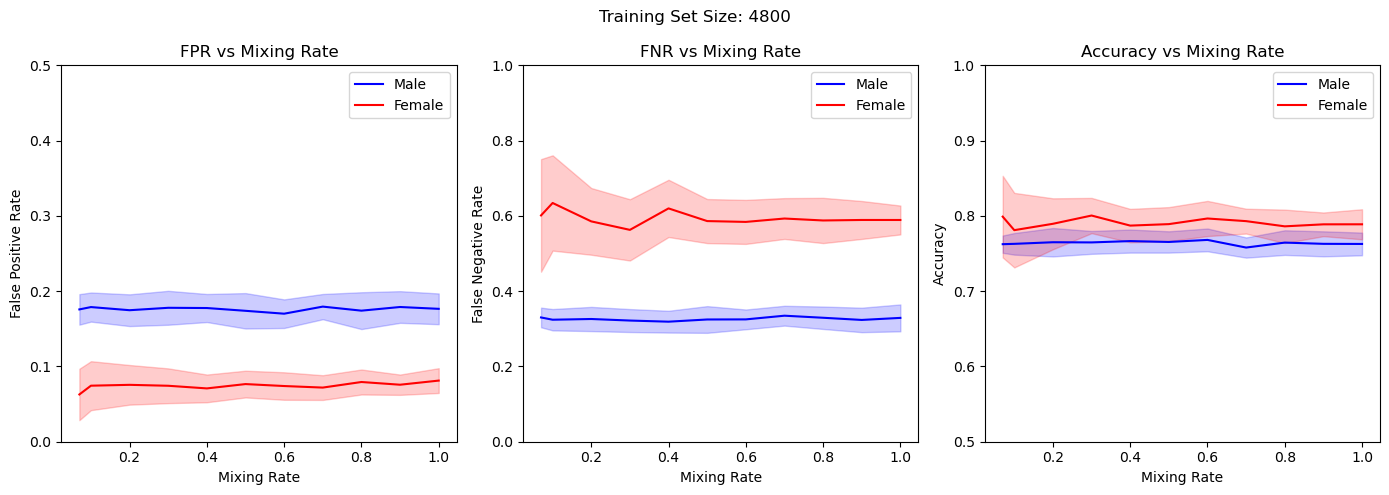

Fixed training set size:  14400
Original training set size: 69247
Original number of females in train set: 33536
Percentage of total females that's being currently graphed: 29.93576284223437%


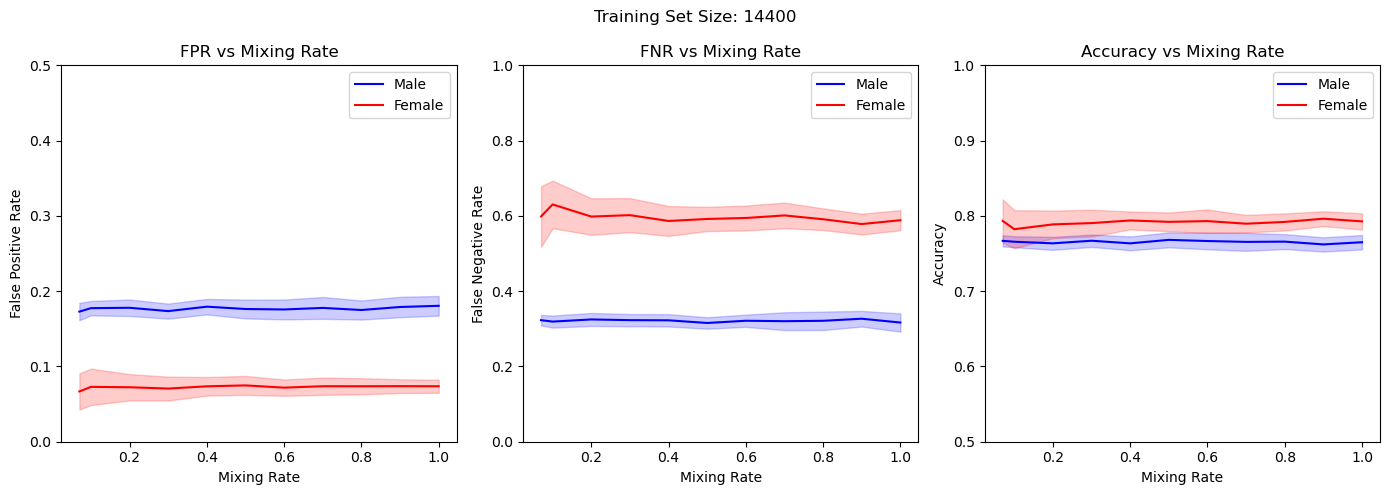

Fixed training set size:  24100
Original training set size: 69247
Original number of females in train set: 33536
Percentage of total females that's being currently graphed: 50.10082531235058%


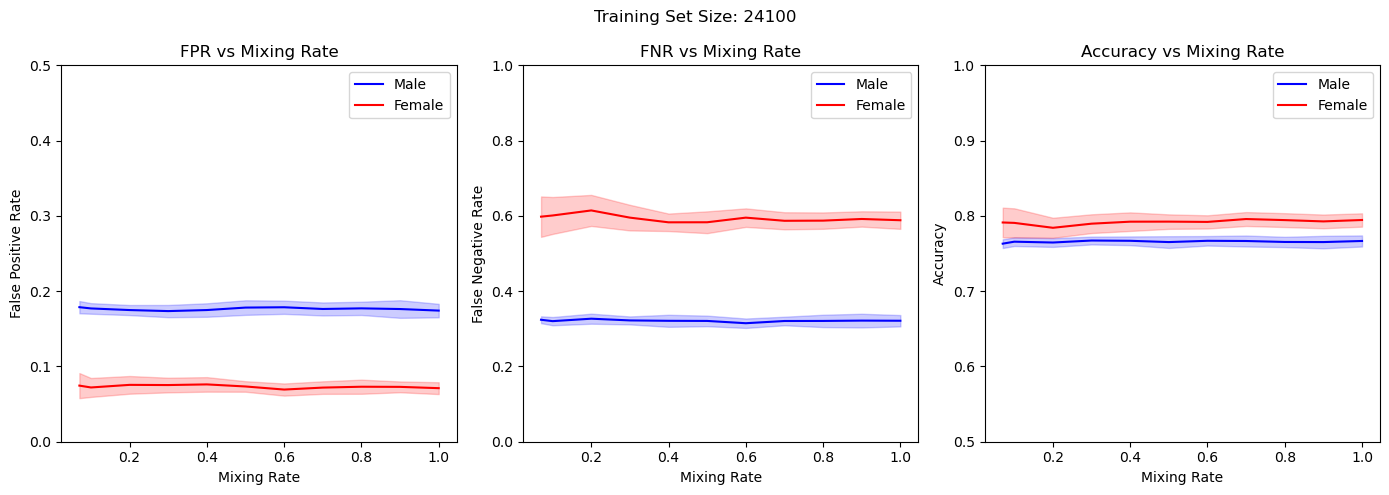

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import folktables
from folktables import ACSDataSource

def fetch_data_for_state(state):
    data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True)
    features, label, group = ACSIncomeNew.df_to_numpy(acs_data)
    return features, label, group

def calculate_metrics(y_true, y_pred):
    # Check if the confusion matrix is empty
    if np.sum(y_true == 1) == 0 or np.sum(y_true == 0) == 0:
        fpr, fnr, acc = np.nan, np.nan, np.nan
    else:
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Extract values from the confusion matrix
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        acc = accuracy_score(y_true, y_pred)
    return fpr, fnr, acc

ACSIncomeNew = folktables.BasicProblem(
    features=[
        'AGEP', # Age (1-99)\n",
        'COW', # Class of Worker (1-9)\n",
        'SCHL', # Education (1-24)\n",
        'MAR', # Marital status (1-5)\n",
        'OCCP', # Occupation 0000-9920\n",
        'POBP', # Place of birth 000-554\n",
        'RELP', ## Relationship (00-17)\n",
        'WKHP',# Hours worked per week (0-99)\n",
        'SEX', # sex (1,2)\n",
        'RAC1P', # race (1-9)\n",
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)



# Evaluation function for different mixing rates and modified sizes
def evaluate_model_with_mixing_rate_and_size(mixing_rate, modified_size, features, labels, groups):
    initial_size = len(features)
    num_males_original = np.sum(groups == 1)
    num_females_original = np.sum(groups == 2)

    female_indices = np.where(groups == 2)[0]
    num_female_to_keep = int(len(female_indices) * mixing_rate)
    subsampled_female_indices = np.random.choice(female_indices, size=num_female_to_keep, replace=False)

    modified_features = np.concatenate([features[groups == 1], features[subsampled_female_indices]])
    modified_labels = np.concatenate([labels[groups == 1], labels[subsampled_female_indices]])
    modified_groups = np.concatenate([groups[groups == 1], groups[subsampled_female_indices]])

    if modified_size is not None and modified_size < len(modified_features):
        subsample_indices = np.random.choice(np.arange(len(modified_features)), size=modified_size, replace=False)
        modified_features = modified_features[subsample_indices]
        modified_labels = modified_labels[subsample_indices]
        modified_groups = modified_groups[subsample_indices]

    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        modified_features, modified_labels, modified_groups, test_size=0.2, random_state=0)

    model = make_pipeline(StandardScaler(), LogisticRegression())
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    fpr_male, fnr_male, acc_male = calculate_metrics(y_test[group_test == 1], y_pred[group_test == 1])
    fpr_female, fnr_female, acc_female = calculate_metrics(y_test[group_test == 2], y_pred[group_test == 2])

    return initial_size, modified_size, num_males_original, num_females_original, len(modified_features), \
           fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female

# Fetch data for California
ca_features, ca_label, ca_group = fetch_data_for_state('FL')

# Split data for training
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    ca_features, ca_label, ca_group, test_size=0.3, random_state=0)

# Train the model
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

mixing_rates = [0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Total females in the dataset
total_females = len(np.where(ca_group == 2)[0])

print("FL 2018 Data")

# Iterate over different fixed training set sizes
fixed_train_sizes = [int(round(0.1 * total_females, -2)), int(round(0.3 * total_females, -2)), int(round(0.5 * total_females, -2))]
for fixed_train_size in fixed_train_sizes:
    print("Fixed training set size: ", fixed_train_size)

    results_subset_list = []
    num_iterations = 30
    for _ in range(num_iterations):
        results_subset = {'Mixing Rate': [], 'FPR Male': [], 'FNR Male': [], 'Accuracy Male': [],
                          'FPR Female': [], 'FNR Female': [], 'Accuracy Female': []}
        for mixing_rate in mixing_rates:
            initial_size, _, num_males_original, num_females_original, _, \
            fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female = \
            evaluate_model_with_mixing_rate_and_size(mixing_rate, fixed_train_size, ca_features, ca_label, ca_group)

            results_subset['Mixing Rate'].append(mixing_rate)
            results_subset['FPR Male'].append(fpr_male)
            results_subset['FNR Male'].append(fnr_male)
            results_subset['Accuracy Male'].append(acc_male)
            results_subset['FPR Female'].append(fpr_female)
            results_subset['FNR Female'].append(fnr_female)
            results_subset['Accuracy Female'].append(acc_female)

        results_subset_list.append(results_subset)

    average_results_subset = {'Mixing Rate': mixing_rates,
                              'FPR Male': np.mean([result['FPR Male'] for result in results_subset_list], axis=0),
                              'FNR Male': np.mean([result['FNR Male'] for result in results_subset_list], axis=0),
                              'Accuracy Male': np.mean([result['Accuracy Male'] for result in results_subset_list], axis=0),
                              'FPR Female': np.mean([result['FPR Female'] for result in results_subset_list], axis=0),
                              'FNR Female': np.mean([result['FNR Female'] for result in results_subset_list], axis=0),
                              'Accuracy Female': np.mean([result['Accuracy Female'] for result in results_subset_list], axis=0)}

    average_results_subset_df = pd.DataFrame(average_results_subset)

    std_results_subset = {'FPR Male': np.std([result['FPR Male'] for result in results_subset_list], axis=0),
                          'FNR Male': np.std([result['FNR Male'] for result in results_subset_list], axis=0),
                          'Accuracy Male': np.std([result['Accuracy Male'] for result in results_subset_list], axis=0),
                          'FPR Female': np.std([result['FPR Female'] for result in results_subset_list], axis=0),
                          'FNR Female': np.std([result['FNR Female'] for result in results_subset_list], axis=0),
                          'Accuracy Female': np.std([result['Accuracy Female'] for result in results_subset_list], axis=0)}
    
    print(f"Original training set size: {len(X_train)}")
    print(f"Original number of females in train set: {np.sum(group_train == 2)}")
    print(f"Percentage of total females that's being currently graphed: {fixed_train_size / total_females * 100}%")


    fig, axs = plt.subplots(1, 3, figsize=(14, 5))
    plt.title('CA 2018: ACSIncome MALE / FEMALE')
    fig.suptitle(f'Training Set Size: {fixed_train_size}')

    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Male'], label='Male', color='blue')
    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Female'], label='Female', color='red')
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Male'] - std_results_subset['FPR Male'],
                       average_results_subset_df['FPR Male'] + std_results_subset['FPR Male'],
                       color='blue', alpha=0.2)
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Female'] - std_results_subset['FPR Female'],
                       average_results_subset_df['FPR Female'] + std_results_subset['FPR Female'],
                       color='red', alpha=0.2)
    axs[0].set_xlabel('Mixing Rate')
    axs[0].set_ylabel('False Positive Rate')
    axs[0].set_title('FPR vs Mixing Rate')
    axs[0].legend()
    axs[0].set_ylim(0, 0.5)

    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Male'], label='Male', color='blue')
    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Female'], label='Female', color='red')
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Male'] - std_results_subset['FNR Male'],
                       average_results_subset_df['FNR Male'] + std_results_subset['FNR Male'],
                       color='blue', alpha=0.2)
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Female'] - std_results_subset['FNR Female'],
                       average_results_subset_df['FNR Female'] + std_results_subset['FNR Female'],
                       color='red', alpha=0.2)
    axs[1].set_xlabel('Mixing Rate')
    axs[1].set_ylabel('False Negative Rate')
    axs[1].set_title('FNR vs Mixing Rate')
    axs[1].legend()
    axs[1].set_ylim(0, 1.0)

    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Male'], label='Male', color='blue')
    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Female'], label='Female', color='red')
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Male'] - std_results_subset['Accuracy Male'],
                       average_results_subset_df['Accuracy Male'] + std_results_subset['Accuracy Male'],
                       color='blue', alpha=0.2)
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Female'] - std_results_subset['Accuracy Female'],
                       average_results_subset_df['Accuracy Female'] + std_results_subset['Accuracy Female'],
                       color='red', alpha=0.2)
    axs[2].set_xlabel('Mixing Rate')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_title('Accuracy vs Mixing Rate')
    axs[2].legend()
    axs[2].set_ylim(0.5, 1.0)

    plt.tight_layout()
    plt.show()


FL 2015

Fixed training set size:  4600
Original training set size: 64906
Original number of females in train set: 31828
Percentage of total females that's being currently graphed: 10.091481473356295%


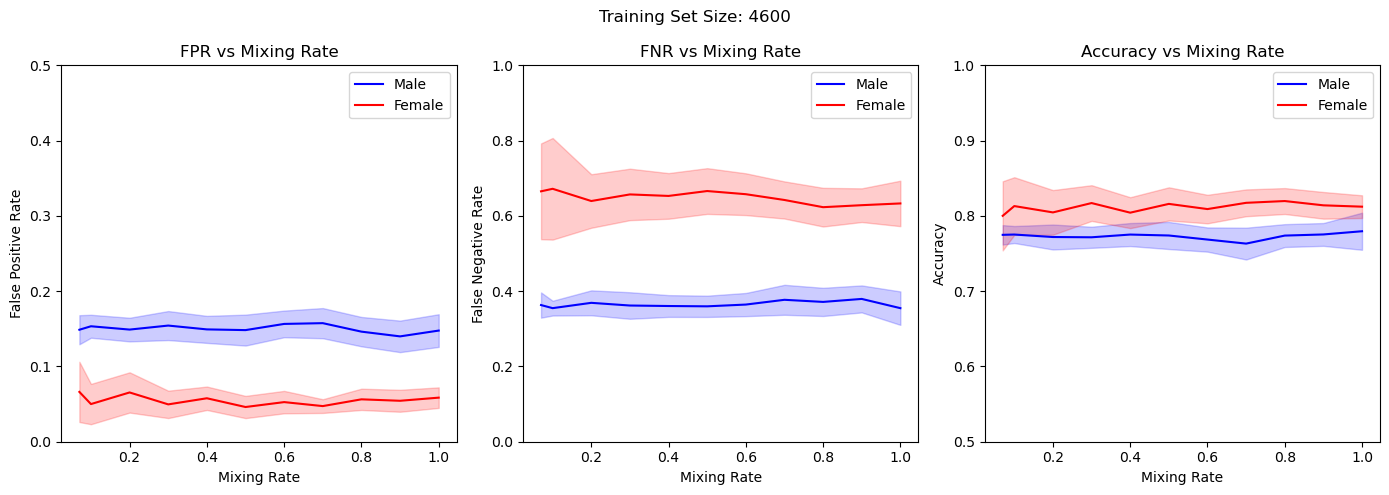

Fixed training set size:  13700
Original training set size: 64906
Original number of females in train set: 31828
Percentage of total females that's being currently graphed: 30.055064388039398%


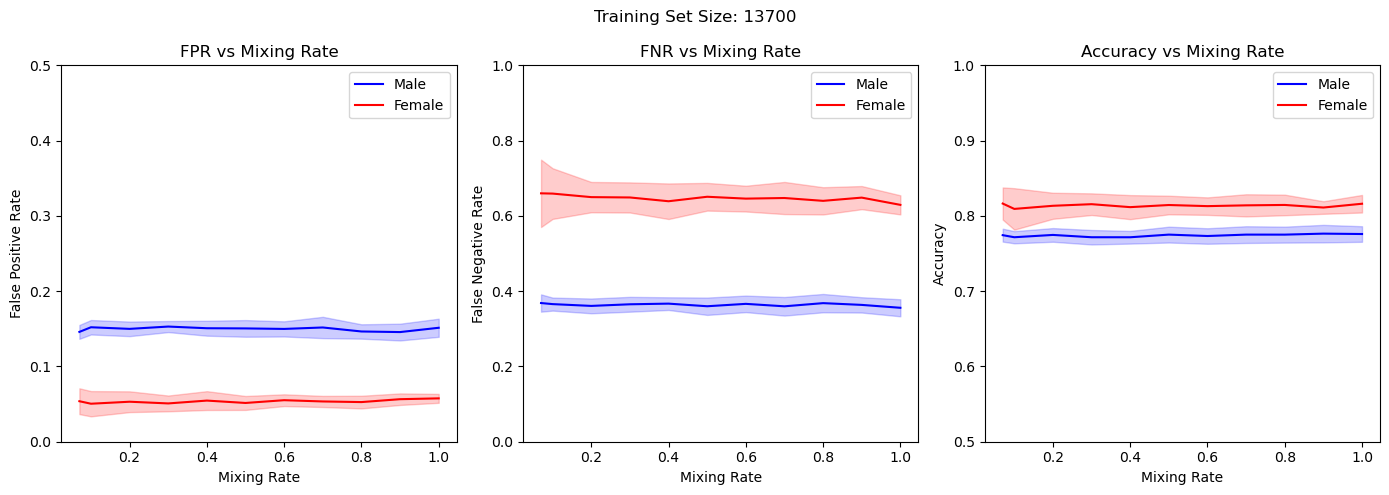

Fixed training set size:  22800
Original training set size: 64906
Original number of females in train set: 31828
Percentage of total females that's being currently graphed: 50.018647302722506%


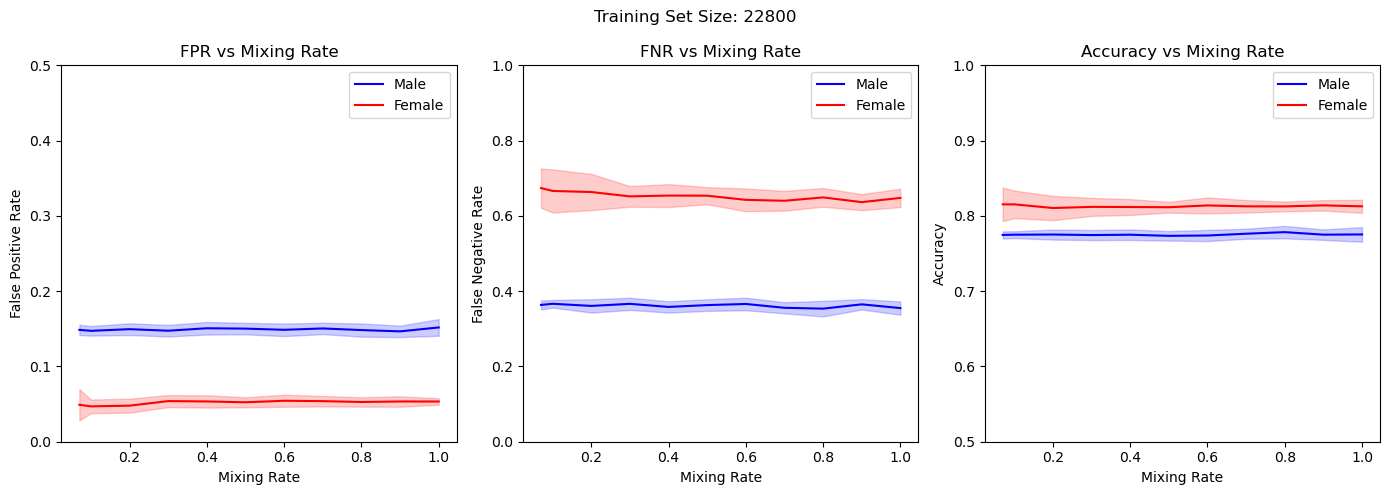

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import folktables
from folktables import ACSDataSource

def fetch_data_for_state(state):
    data_source = ACSDataSource(survey_year='2015', horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True)
    features, label, group = ACSIncomeNew.df_to_numpy(acs_data)
    return features, label, group

def calculate_metrics(y_true, y_pred):
    # Check if the confusion matrix is empty
    if np.sum(y_true == 1) == 0 or np.sum(y_true == 0) == 0:
        fpr, fnr, acc = np.nan, np.nan, np.nan
    else:
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Extract values from the confusion matrix
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        acc = accuracy_score(y_true, y_pred)
    return fpr, fnr, acc

ACSIncomeNew = folktables.BasicProblem(
    features=[
        'AGEP', # Age (1-99)\n",
        'COW', # Class of Worker (1-9)\n",
        'SCHL', # Education (1-24)\n",
        'MAR', # Marital status (1-5)\n",
        'OCCP', # Occupation 0000-9920\n",
        'POBP', # Place of birth 000-554\n",
        'RELP', ## Relationship (00-17)\n",
        'WKHP',# Hours worked per week (0-99)\n",
        'SEX', # sex (1,2)\n",
        'RAC1P', # race (1-9)\n",
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)



# Evaluation function for different mixing rates and modified sizes
def evaluate_model_with_mixing_rate_and_size(mixing_rate, modified_size, features, labels, groups):
    initial_size = len(features)
    num_males_original = np.sum(groups == 1)
    num_females_original = np.sum(groups == 2)

    female_indices = np.where(groups == 2)[0]
    num_female_to_keep = int(len(female_indices) * mixing_rate)
    subsampled_female_indices = np.random.choice(female_indices, size=num_female_to_keep, replace=False)

    modified_features = np.concatenate([features[groups == 1], features[subsampled_female_indices]])
    modified_labels = np.concatenate([labels[groups == 1], labels[subsampled_female_indices]])
    modified_groups = np.concatenate([groups[groups == 1], groups[subsampled_female_indices]])

    if modified_size is not None and modified_size < len(modified_features):
        subsample_indices = np.random.choice(np.arange(len(modified_features)), size=modified_size, replace=False)
        modified_features = modified_features[subsample_indices]
        modified_labels = modified_labels[subsample_indices]
        modified_groups = modified_groups[subsample_indices]

    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        modified_features, modified_labels, modified_groups, test_size=0.2, random_state=0)

    model = make_pipeline(StandardScaler(), LogisticRegression())
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    fpr_male, fnr_male, acc_male = calculate_metrics(y_test[group_test == 1], y_pred[group_test == 1])
    fpr_female, fnr_female, acc_female = calculate_metrics(y_test[group_test == 2], y_pred[group_test == 2])

    return initial_size, modified_size, num_males_original, num_females_original, len(modified_features), \
           fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female

# Fetch data for California
ca_features, ca_label, ca_group = fetch_data_for_state('FL')

# Split data for training
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    ca_features, ca_label, ca_group, test_size=0.3, random_state=0)

# Train the model
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

mixing_rates = [0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Total females in the dataset
total_females = len(np.where(ca_group == 2)[0])

print("FL 2015 Data")

# Iterate over different fixed training set sizes
fixed_train_sizes = [int(round(0.1 * total_females, -2)), int(round(0.3 * total_females, -2)), int(round(0.5 * total_females, -2))]
for fixed_train_size in fixed_train_sizes:
    print("Fixed training set size: ", fixed_train_size)

    results_subset_list = []
    num_iterations = 30
    for _ in range(num_iterations):
        results_subset = {'Mixing Rate': [], 'FPR Male': [], 'FNR Male': [], 'Accuracy Male': [],
                          'FPR Female': [], 'FNR Female': [], 'Accuracy Female': []}
        for mixing_rate in mixing_rates:
            initial_size, _, num_males_original, num_females_original, _, \
            fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female = \
            evaluate_model_with_mixing_rate_and_size(mixing_rate, fixed_train_size, ca_features, ca_label, ca_group)

            results_subset['Mixing Rate'].append(mixing_rate)
            results_subset['FPR Male'].append(fpr_male)
            results_subset['FNR Male'].append(fnr_male)
            results_subset['Accuracy Male'].append(acc_male)
            results_subset['FPR Female'].append(fpr_female)
            results_subset['FNR Female'].append(fnr_female)
            results_subset['Accuracy Female'].append(acc_female)

        results_subset_list.append(results_subset)

    average_results_subset = {'Mixing Rate': mixing_rates,
                              'FPR Male': np.mean([result['FPR Male'] for result in results_subset_list], axis=0),
                              'FNR Male': np.mean([result['FNR Male'] for result in results_subset_list], axis=0),
                              'Accuracy Male': np.mean([result['Accuracy Male'] for result in results_subset_list], axis=0),
                              'FPR Female': np.mean([result['FPR Female'] for result in results_subset_list], axis=0),
                              'FNR Female': np.mean([result['FNR Female'] for result in results_subset_list], axis=0),
                              'Accuracy Female': np.mean([result['Accuracy Female'] for result in results_subset_list], axis=0)}

    average_results_subset_df = pd.DataFrame(average_results_subset)

    std_results_subset = {'FPR Male': np.std([result['FPR Male'] for result in results_subset_list], axis=0),
                          'FNR Male': np.std([result['FNR Male'] for result in results_subset_list], axis=0),
                          'Accuracy Male': np.std([result['Accuracy Male'] for result in results_subset_list], axis=0),
                          'FPR Female': np.std([result['FPR Female'] for result in results_subset_list], axis=0),
                          'FNR Female': np.std([result['FNR Female'] for result in results_subset_list], axis=0),
                          'Accuracy Female': np.std([result['Accuracy Female'] for result in results_subset_list], axis=0)}
    
    print(f"Original training set size: {len(X_train)}")
    print(f"Original number of females in train set: {np.sum(group_train == 2)}")
    print(f"Percentage of total females that's being currently graphed: {fixed_train_size / total_females * 100}%")


    fig, axs = plt.subplots(1, 3, figsize=(14, 5))
    plt.title('CA 2018: ACSIncome MALE / FEMALE')
    fig.suptitle(f'Training Set Size: {fixed_train_size}')

    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Male'], label='Male', color='blue')
    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Female'], label='Female', color='red')
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Male'] - std_results_subset['FPR Male'],
                       average_results_subset_df['FPR Male'] + std_results_subset['FPR Male'],
                       color='blue', alpha=0.2)
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Female'] - std_results_subset['FPR Female'],
                       average_results_subset_df['FPR Female'] + std_results_subset['FPR Female'],
                       color='red', alpha=0.2)
    axs[0].set_xlabel('Mixing Rate')
    axs[0].set_ylabel('False Positive Rate')
    axs[0].set_title('FPR vs Mixing Rate')
    axs[0].legend()
    axs[0].set_ylim(0, 0.5)

    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Male'], label='Male', color='blue')
    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Female'], label='Female', color='red')
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Male'] - std_results_subset['FNR Male'],
                       average_results_subset_df['FNR Male'] + std_results_subset['FNR Male'],
                       color='blue', alpha=0.2)
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Female'] - std_results_subset['FNR Female'],
                       average_results_subset_df['FNR Female'] + std_results_subset['FNR Female'],
                       color='red', alpha=0.2)
    axs[1].set_xlabel('Mixing Rate')
    axs[1].set_ylabel('False Negative Rate')
    axs[1].set_title('FNR vs Mixing Rate')
    axs[1].legend()
    axs[1].set_ylim(0, 1.0)

    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Male'], label='Male', color='blue')
    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Female'], label='Female', color='red')
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Male'] - std_results_subset['Accuracy Male'],
                       average_results_subset_df['Accuracy Male'] + std_results_subset['Accuracy Male'],
                       color='blue', alpha=0.2)
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Female'] - std_results_subset['Accuracy Female'],
                       average_results_subset_df['Accuracy Female'] + std_results_subset['Accuracy Female'],
                       color='red', alpha=0.2)
    axs[2].set_xlabel('Mixing Rate')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_title('Accuracy vs Mixing Rate')
    axs[2].legend()
    axs[2].set_ylim(0.5, 1.0)

    plt.tight_layout()
    plt.show()


FL 2017

Fixed training set size:  4700
Original training set size: 68066
Original number of females in train set: 33058
Percentage of total females that's being currently graphed: 9.93573482157957%


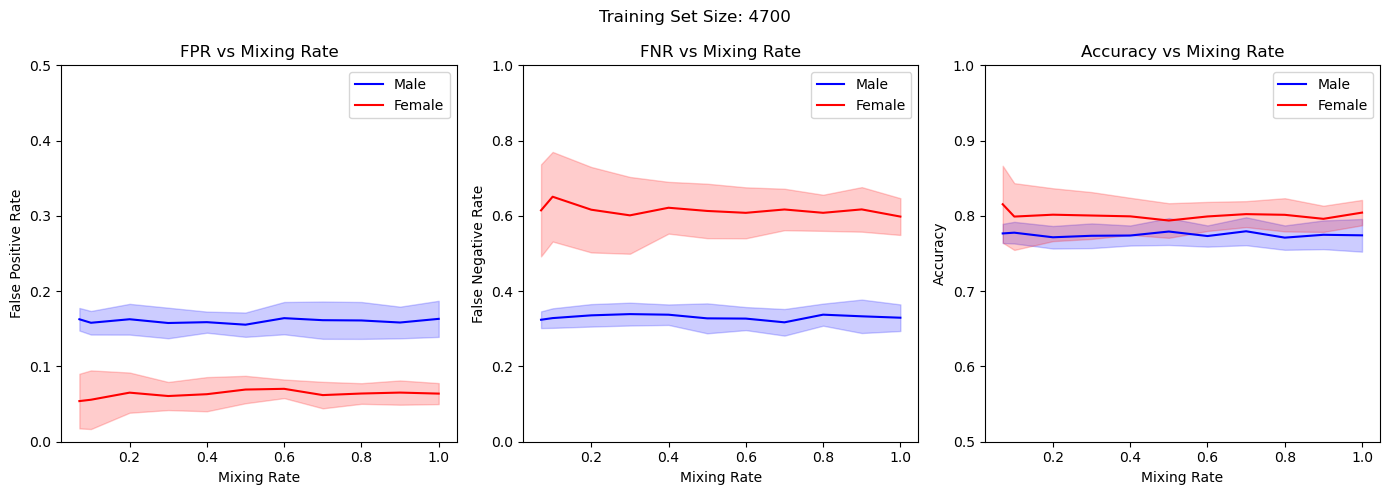

Fixed training set size:  14200
Original training set size: 68066
Original number of females in train set: 33058
Percentage of total females that's being currently graphed: 30.018603077963807%


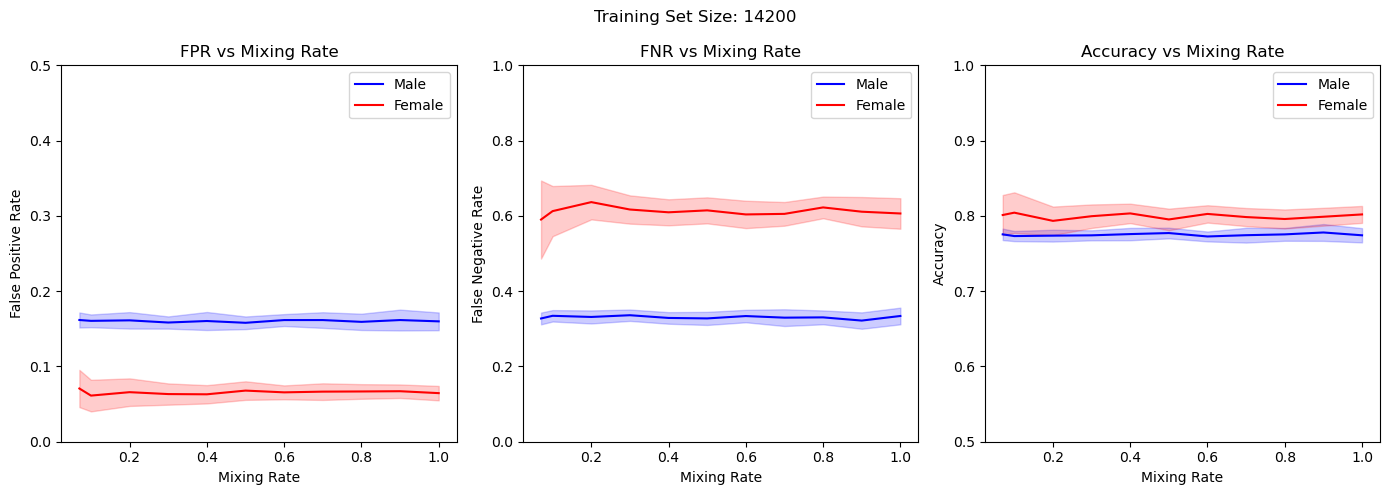

Fixed training set size:  23700
Original training set size: 68066
Original number of females in train set: 33058
Percentage of total females that's being currently graphed: 50.10147133434805%


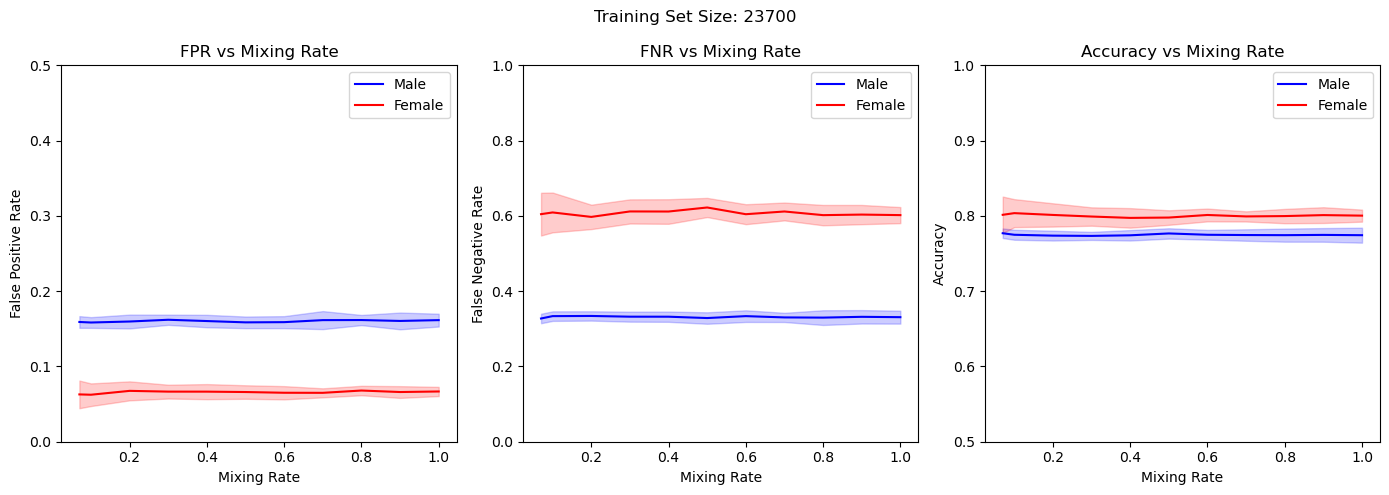

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import folktables
from folktables import ACSDataSource

def fetch_data_for_state(state):
    data_source = ACSDataSource(survey_year='2017', horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True)
    features, label, group = ACSIncomeNew.df_to_numpy(acs_data)
    return features, label, group

def calculate_metrics(y_true, y_pred):
    # Check if the confusion matrix is empty
    if np.sum(y_true == 1) == 0 or np.sum(y_true == 0) == 0:
        fpr, fnr, acc = np.nan, np.nan, np.nan
    else:
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Extract values from the confusion matrix
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        acc = accuracy_score(y_true, y_pred)
    return fpr, fnr, acc

ACSIncomeNew = folktables.BasicProblem(
    features=[
        'AGEP', # Age (1-99)\n",
        'COW', # Class of Worker (1-9)\n",
        'SCHL', # Education (1-24)\n",
        'MAR', # Marital status (1-5)\n",
        'OCCP', # Occupation 0000-9920\n",
        'POBP', # Place of birth 000-554\n",
        'RELP', ## Relationship (00-17)\n",
        'WKHP',# Hours worked per week (0-99)\n",
        'SEX', # sex (1,2)\n",
        'RAC1P', # race (1-9)\n",
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)



# Evaluation function for different mixing rates and modified sizes
def evaluate_model_with_mixing_rate_and_size(mixing_rate, modified_size, features, labels, groups):
    initial_size = len(features)
    num_males_original = np.sum(groups == 1)
    num_females_original = np.sum(groups == 2)

    female_indices = np.where(groups == 2)[0]
    num_female_to_keep = int(len(female_indices) * mixing_rate)
    subsampled_female_indices = np.random.choice(female_indices, size=num_female_to_keep, replace=False)

    modified_features = np.concatenate([features[groups == 1], features[subsampled_female_indices]])
    modified_labels = np.concatenate([labels[groups == 1], labels[subsampled_female_indices]])
    modified_groups = np.concatenate([groups[groups == 1], groups[subsampled_female_indices]])

    if modified_size is not None and modified_size < len(modified_features):
        subsample_indices = np.random.choice(np.arange(len(modified_features)), size=modified_size, replace=False)
        modified_features = modified_features[subsample_indices]
        modified_labels = modified_labels[subsample_indices]
        modified_groups = modified_groups[subsample_indices]

    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        modified_features, modified_labels, modified_groups, test_size=0.2, random_state=0)

    model = make_pipeline(StandardScaler(), LogisticRegression())
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    fpr_male, fnr_male, acc_male = calculate_metrics(y_test[group_test == 1], y_pred[group_test == 1])
    fpr_female, fnr_female, acc_female = calculate_metrics(y_test[group_test == 2], y_pred[group_test == 2])

    return initial_size, modified_size, num_males_original, num_females_original, len(modified_features), \
           fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female

# Fetch data for California
ca_features, ca_label, ca_group = fetch_data_for_state('FL')

# Split data for training
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    ca_features, ca_label, ca_group, test_size=0.3, random_state=0)

# Train the model
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

mixing_rates = [0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Total females in the dataset
total_females = len(np.where(ca_group == 2)[0])

# Iterate over different fixed training set sizes
fixed_train_sizes = [int(round(0.1 * total_females, -2)), int(round(0.3 * total_females, -2)), int(round(0.5 * total_females, -2))]
for fixed_train_size in fixed_train_sizes:
    print("Fixed training set size: ", fixed_train_size)

    results_subset_list = []
    num_iterations = 30
    for _ in range(num_iterations):
        results_subset = {'Mixing Rate': [], 'FPR Male': [], 'FNR Male': [], 'Accuracy Male': [],
                          'FPR Female': [], 'FNR Female': [], 'Accuracy Female': []}
        for mixing_rate in mixing_rates:
            initial_size, _, num_males_original, num_females_original, _, \
            fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female = \
            evaluate_model_with_mixing_rate_and_size(mixing_rate, fixed_train_size, ca_features, ca_label, ca_group)

            results_subset['Mixing Rate'].append(mixing_rate)
            results_subset['FPR Male'].append(fpr_male)
            results_subset['FNR Male'].append(fnr_male)
            results_subset['Accuracy Male'].append(acc_male)
            results_subset['FPR Female'].append(fpr_female)
            results_subset['FNR Female'].append(fnr_female)
            results_subset['Accuracy Female'].append(acc_female)

        results_subset_list.append(results_subset)

    average_results_subset = {'Mixing Rate': mixing_rates,
                              'FPR Male': np.mean([result['FPR Male'] for result in results_subset_list], axis=0),
                              'FNR Male': np.mean([result['FNR Male'] for result in results_subset_list], axis=0),
                              'Accuracy Male': np.mean([result['Accuracy Male'] for result in results_subset_list], axis=0),
                              'FPR Female': np.mean([result['FPR Female'] for result in results_subset_list], axis=0),
                              'FNR Female': np.mean([result['FNR Female'] for result in results_subset_list], axis=0),
                              'Accuracy Female': np.mean([result['Accuracy Female'] for result in results_subset_list], axis=0)}

    average_results_subset_df = pd.DataFrame(average_results_subset)

    std_results_subset = {'FPR Male': np.std([result['FPR Male'] for result in results_subset_list], axis=0),
                          'FNR Male': np.std([result['FNR Male'] for result in results_subset_list], axis=0),
                          'Accuracy Male': np.std([result['Accuracy Male'] for result in results_subset_list], axis=0),
                          'FPR Female': np.std([result['FPR Female'] for result in results_subset_list], axis=0),
                          'FNR Female': np.std([result['FNR Female'] for result in results_subset_list], axis=0),
                          'Accuracy Female': np.std([result['Accuracy Female'] for result in results_subset_list], axis=0)}
    
    print(f"Original training set size: {len(X_train)}")
    print(f"Original number of females in train set: {np.sum(group_train == 2)}")
    print(f"Percentage of total females that's being currently graphed: {fixed_train_size / total_females * 100}%")


    fig, axs = plt.subplots(1, 3, figsize=(14, 5))
    plt.title('CA 2018: ACSIncome MALE / FEMALE')
    fig.suptitle(f'Training Set Size: {fixed_train_size}')

    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Male'], label='Male', color='blue')
    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Female'], label='Female', color='red')
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Male'] - std_results_subset['FPR Male'],
                       average_results_subset_df['FPR Male'] + std_results_subset['FPR Male'],
                       color='blue', alpha=0.2)
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Female'] - std_results_subset['FPR Female'],
                       average_results_subset_df['FPR Female'] + std_results_subset['FPR Female'],
                       color='red', alpha=0.2)
    axs[0].set_xlabel('Mixing Rate')
    axs[0].set_ylabel('False Positive Rate')
    axs[0].set_title('FPR vs Mixing Rate')
    axs[0].legend()
    axs[0].set_ylim(0, 0.5)

    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Male'], label='Male', color='blue')
    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Female'], label='Female', color='red')
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Male'] - std_results_subset['FNR Male'],
                       average_results_subset_df['FNR Male'] + std_results_subset['FNR Male'],
                       color='blue', alpha=0.2)
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Female'] - std_results_subset['FNR Female'],
                       average_results_subset_df['FNR Female'] + std_results_subset['FNR Female'],
                       color='red', alpha=0.2)
    axs[1].set_xlabel('Mixing Rate')
    axs[1].set_ylabel('False Negative Rate')
    axs[1].set_title('FNR vs Mixing Rate')
    axs[1].legend()
    axs[1].set_ylim(0, 1.0)

    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Male'], label='Male', color='blue')
    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Female'], label='Female', color='red')
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Male'] - std_results_subset['Accuracy Male'],
                       average_results_subset_df['Accuracy Male'] + std_results_subset['Accuracy Male'],
                       color='blue', alpha=0.2)
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Female'] - std_results_subset['Accuracy Female'],
                       average_results_subset_df['Accuracy Female'] + std_results_subset['Accuracy Female'],
                       color='red', alpha=0.2)
    axs[2].set_xlabel('Mixing Rate')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_title('Accuracy vs Mixing Rate')
    axs[2].legend()
    axs[2].set_ylim(0.5, 1.0)

    plt.tight_layout()
    plt.show()


TX 2018, 2015, 2017

TX 2018

Fixed training set size:  6400
Original training set size: 95146
Original number of females in train set: 44624
Percentage of total females that's being currently graphed: 10.047884449328832%


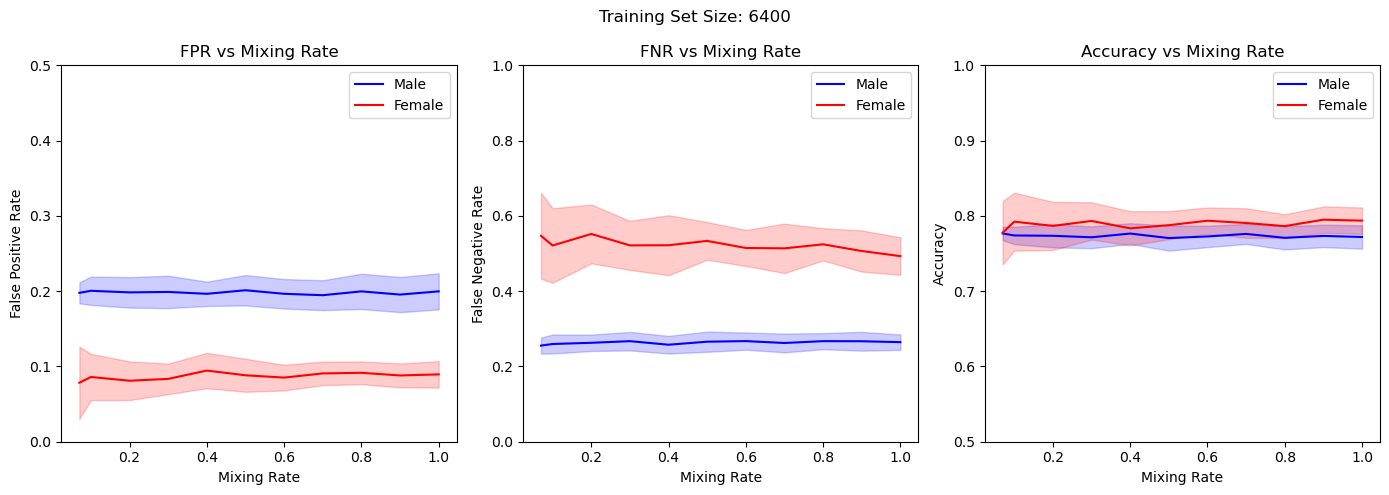

Fixed training set size:  19100
Original training set size: 95146
Original number of females in train set: 44624
Percentage of total females that's being currently graphed: 29.986655153465737%


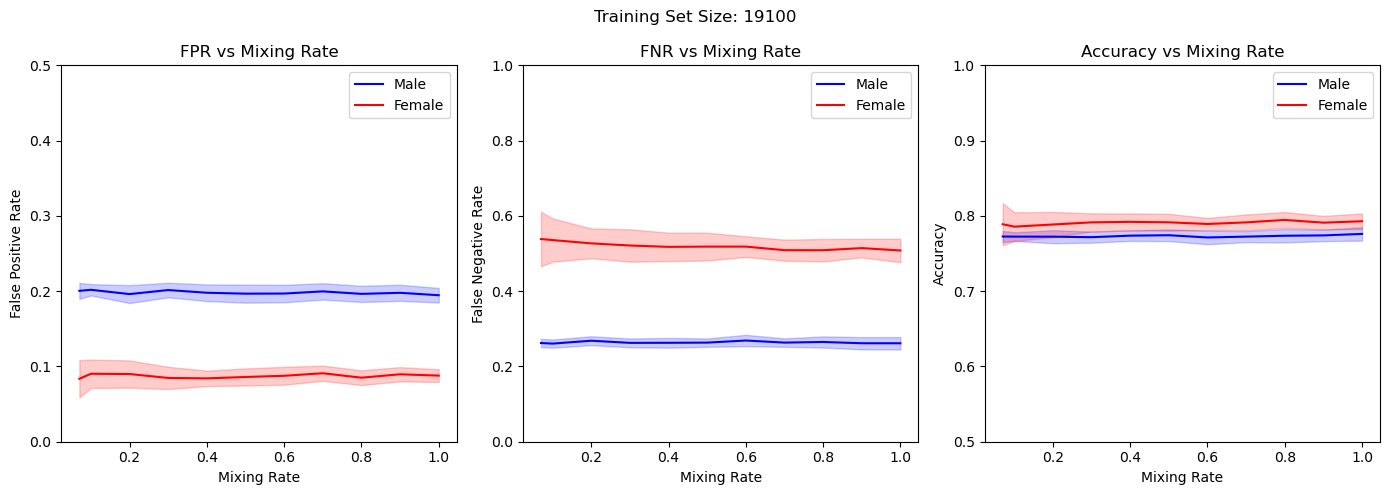

Fixed training set size:  31800
Original training set size: 95146
Original number of females in train set: 44624
Percentage of total females that's being currently graphed: 49.92542585760264%


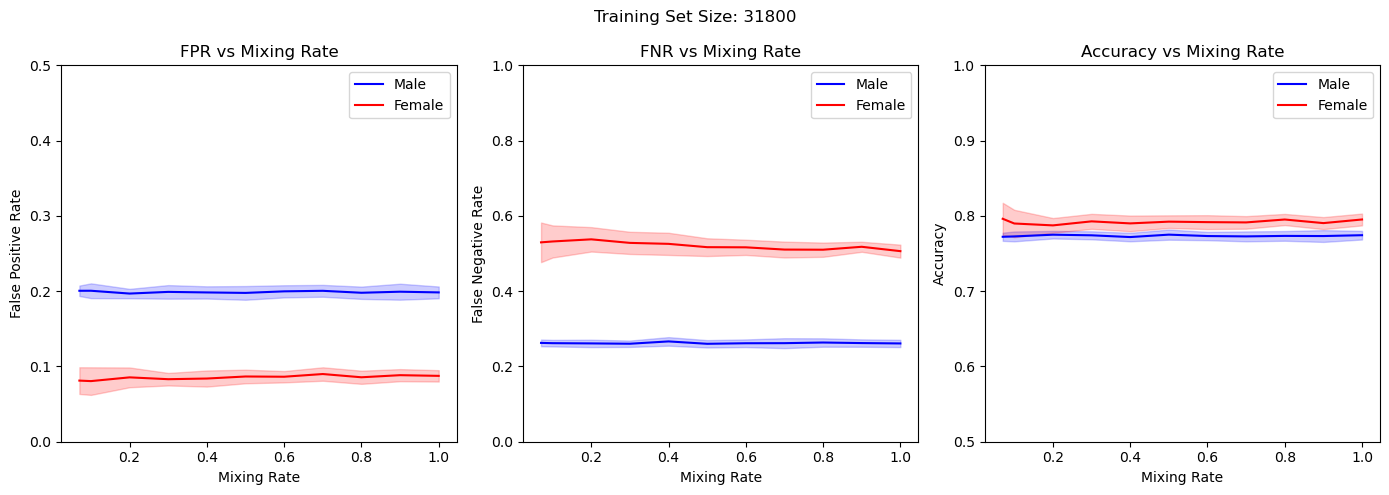

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import folktables
from folktables import ACSDataSource

def fetch_data_for_state(state):
    data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True)
    features, label, group = ACSIncomeNew.df_to_numpy(acs_data)
    return features, label, group

def calculate_metrics(y_true, y_pred):
    # Check if the confusion matrix is empty
    if np.sum(y_true == 1) == 0 or np.sum(y_true == 0) == 0:
        fpr, fnr, acc = np.nan, np.nan, np.nan
    else:
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Extract values from the confusion matrix
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        acc = accuracy_score(y_true, y_pred)
    return fpr, fnr, acc

ACSIncomeNew = folktables.BasicProblem(
    features=[
        'AGEP', # Age (1-99)\n",
        'COW', # Class of Worker (1-9)\n",
        'SCHL', # Education (1-24)\n",
        'MAR', # Marital status (1-5)\n",
        'OCCP', # Occupation 0000-9920\n",
        'POBP', # Place of birth 000-554\n",
        'RELP', ## Relationship (00-17)\n",
        'WKHP',# Hours worked per week (0-99)\n",
        'SEX', # sex (1,2)\n",
        'RAC1P', # race (1-9)\n",
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)



# Evaluation function for different mixing rates and modified sizes
def evaluate_model_with_mixing_rate_and_size(mixing_rate, modified_size, features, labels, groups):
    initial_size = len(features)
    num_males_original = np.sum(groups == 1)
    num_females_original = np.sum(groups == 2)

    female_indices = np.where(groups == 2)[0]
    num_female_to_keep = int(len(female_indices) * mixing_rate)
    subsampled_female_indices = np.random.choice(female_indices, size=num_female_to_keep, replace=False)

    modified_features = np.concatenate([features[groups == 1], features[subsampled_female_indices]])
    modified_labels = np.concatenate([labels[groups == 1], labels[subsampled_female_indices]])
    modified_groups = np.concatenate([groups[groups == 1], groups[subsampled_female_indices]])

    if modified_size is not None and modified_size < len(modified_features):
        subsample_indices = np.random.choice(np.arange(len(modified_features)), size=modified_size, replace=False)
        modified_features = modified_features[subsample_indices]
        modified_labels = modified_labels[subsample_indices]
        modified_groups = modified_groups[subsample_indices]

    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        modified_features, modified_labels, modified_groups, test_size=0.2, random_state=0)

    model = make_pipeline(StandardScaler(), LogisticRegression())
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    fpr_male, fnr_male, acc_male = calculate_metrics(y_test[group_test == 1], y_pred[group_test == 1])
    fpr_female, fnr_female, acc_female = calculate_metrics(y_test[group_test == 2], y_pred[group_test == 2])

    return initial_size, modified_size, num_males_original, num_females_original, len(modified_features), \
           fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female

# Fetch data for California
ca_features, ca_label, ca_group = fetch_data_for_state('TX')

# Split data for training
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    ca_features, ca_label, ca_group, test_size=0.3, random_state=0)

# Train the model
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

mixing_rates = [0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Total females in the dataset
total_females = len(np.where(ca_group == 2)[0])

print("TX 2018 Data")

# Iterate over different fixed training set sizes
fixed_train_sizes = [int(round(0.1 * total_females, -2)), int(round(0.3 * total_females, -2)), int(round(0.5 * total_females, -2))]
for fixed_train_size in fixed_train_sizes:
    print("Fixed training set size: ", fixed_train_size)

    results_subset_list = []
    num_iterations = 30
    for _ in range(num_iterations):
        results_subset = {'Mixing Rate': [], 'FPR Male': [], 'FNR Male': [], 'Accuracy Male': [],
                          'FPR Female': [], 'FNR Female': [], 'Accuracy Female': []}
        for mixing_rate in mixing_rates:
            initial_size, _, num_males_original, num_females_original, _, \
            fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female = \
            evaluate_model_with_mixing_rate_and_size(mixing_rate, fixed_train_size, ca_features, ca_label, ca_group)

            results_subset['Mixing Rate'].append(mixing_rate)
            results_subset['FPR Male'].append(fpr_male)
            results_subset['FNR Male'].append(fnr_male)
            results_subset['Accuracy Male'].append(acc_male)
            results_subset['FPR Female'].append(fpr_female)
            results_subset['FNR Female'].append(fnr_female)
            results_subset['Accuracy Female'].append(acc_female)

        results_subset_list.append(results_subset)

    average_results_subset = {'Mixing Rate': mixing_rates,
                              'FPR Male': np.mean([result['FPR Male'] for result in results_subset_list], axis=0),
                              'FNR Male': np.mean([result['FNR Male'] for result in results_subset_list], axis=0),
                              'Accuracy Male': np.mean([result['Accuracy Male'] for result in results_subset_list], axis=0),
                              'FPR Female': np.mean([result['FPR Female'] for result in results_subset_list], axis=0),
                              'FNR Female': np.mean([result['FNR Female'] for result in results_subset_list], axis=0),
                              'Accuracy Female': np.mean([result['Accuracy Female'] for result in results_subset_list], axis=0)}

    average_results_subset_df = pd.DataFrame(average_results_subset)

    std_results_subset = {'FPR Male': np.std([result['FPR Male'] for result in results_subset_list], axis=0),
                          'FNR Male': np.std([result['FNR Male'] for result in results_subset_list], axis=0),
                          'Accuracy Male': np.std([result['Accuracy Male'] for result in results_subset_list], axis=0),
                          'FPR Female': np.std([result['FPR Female'] for result in results_subset_list], axis=0),
                          'FNR Female': np.std([result['FNR Female'] for result in results_subset_list], axis=0),
                          'Accuracy Female': np.std([result['Accuracy Female'] for result in results_subset_list], axis=0)}
    
    print(f"Original training set size: {len(X_train)}")
    print(f"Original number of females in train set: {np.sum(group_train == 2)}")
    print(f"Percentage of total females that's being currently graphed: {fixed_train_size / total_females * 100}%")


    fig, axs = plt.subplots(1, 3, figsize=(14, 5))
    plt.title('CA 2018: ACSIncome MALE / FEMALE')
    fig.suptitle(f'Training Set Size: {fixed_train_size}')

    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Male'], label='Male', color='blue')
    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Female'], label='Female', color='red')
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Male'] - std_results_subset['FPR Male'],
                       average_results_subset_df['FPR Male'] + std_results_subset['FPR Male'],
                       color='blue', alpha=0.2)
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Female'] - std_results_subset['FPR Female'],
                       average_results_subset_df['FPR Female'] + std_results_subset['FPR Female'],
                       color='red', alpha=0.2)
    axs[0].set_xlabel('Mixing Rate')
    axs[0].set_ylabel('False Positive Rate')
    axs[0].set_title('FPR vs Mixing Rate')
    axs[0].legend()
    axs[0].set_ylim(0, 0.5)

    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Male'], label='Male', color='blue')
    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Female'], label='Female', color='red')
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Male'] - std_results_subset['FNR Male'],
                       average_results_subset_df['FNR Male'] + std_results_subset['FNR Male'],
                       color='blue', alpha=0.2)
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Female'] - std_results_subset['FNR Female'],
                       average_results_subset_df['FNR Female'] + std_results_subset['FNR Female'],
                       color='red', alpha=0.2)
    axs[1].set_xlabel('Mixing Rate')
    axs[1].set_ylabel('False Negative Rate')
    axs[1].set_title('FNR vs Mixing Rate')
    axs[1].legend()
    axs[1].set_ylim(0, 1.0)

    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Male'], label='Male', color='blue')
    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Female'], label='Female', color='red')
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Male'] - std_results_subset['Accuracy Male'],
                       average_results_subset_df['Accuracy Male'] + std_results_subset['Accuracy Male'],
                       color='blue', alpha=0.2)
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Female'] - std_results_subset['Accuracy Female'],
                       average_results_subset_df['Accuracy Female'] + std_results_subset['Accuracy Female'],
                       color='red', alpha=0.2)
    axs[2].set_xlabel('Mixing Rate')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_title('Accuracy vs Mixing Rate')
    axs[2].legend()
    axs[2].set_ylim(0.5, 1.0)

    plt.tight_layout()
    plt.show()


TX 2015

TX 2015 Data
Fixed training set size:  9000
Original training set size: 135050
Original number of females in train set: 63200
Percentage of total females that's being currently graphed: 9.956853634251576%


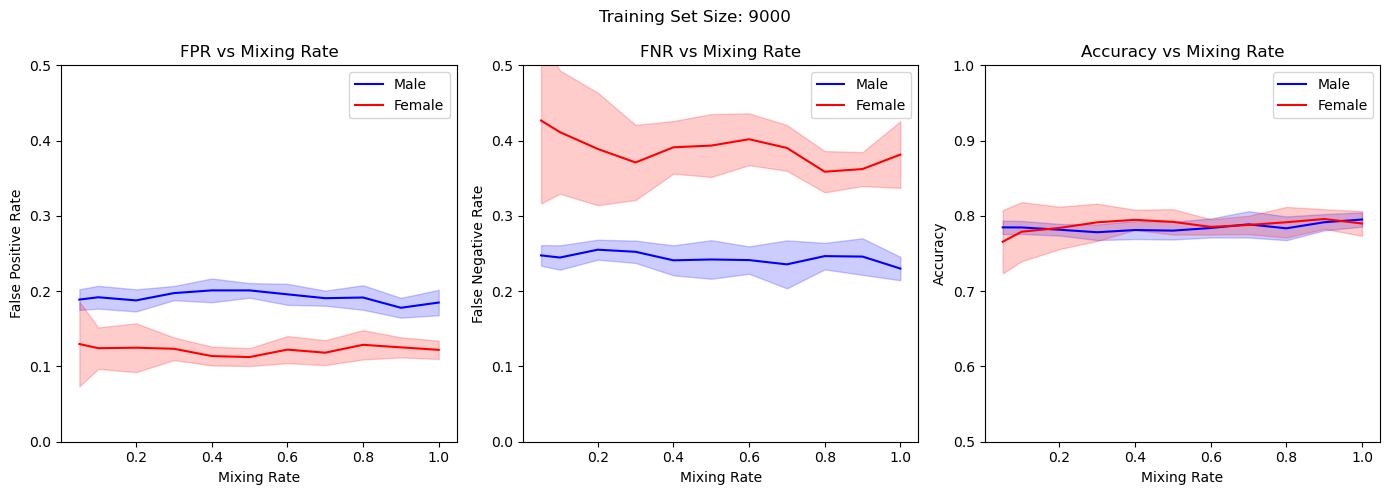

Fixed training set size:  27100
Original training set size: 135050
Original number of females in train set: 63200
Percentage of total females that's being currently graphed: 29.981192609801973%


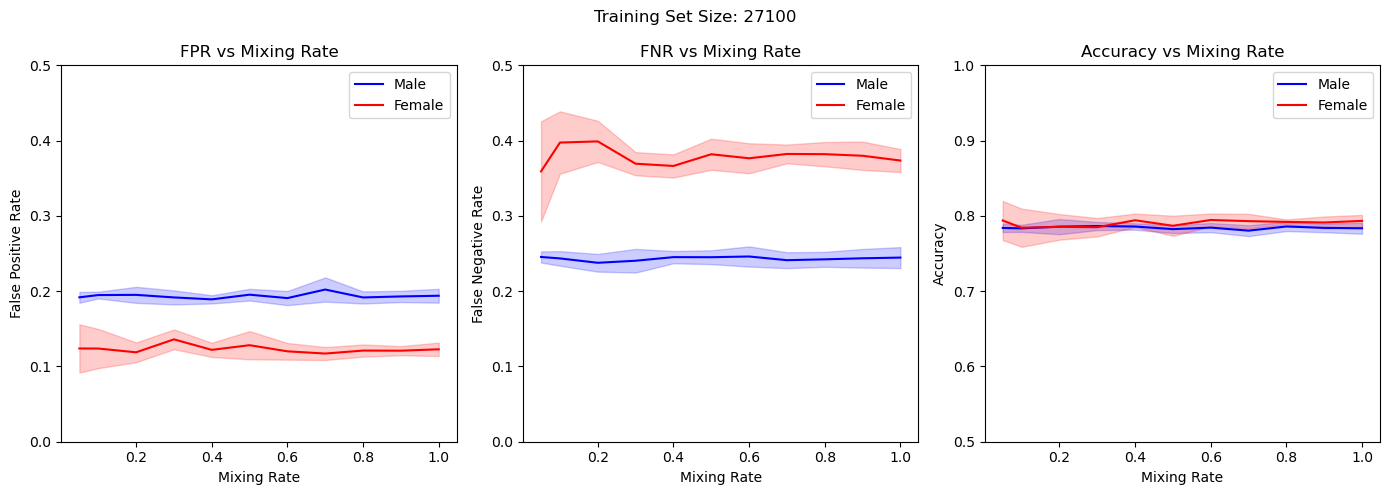

Fixed training set size:  45200
Original training set size: 135050
Original number of females in train set: 63200
Percentage of total females that's being currently graphed: 50.00553158535236%


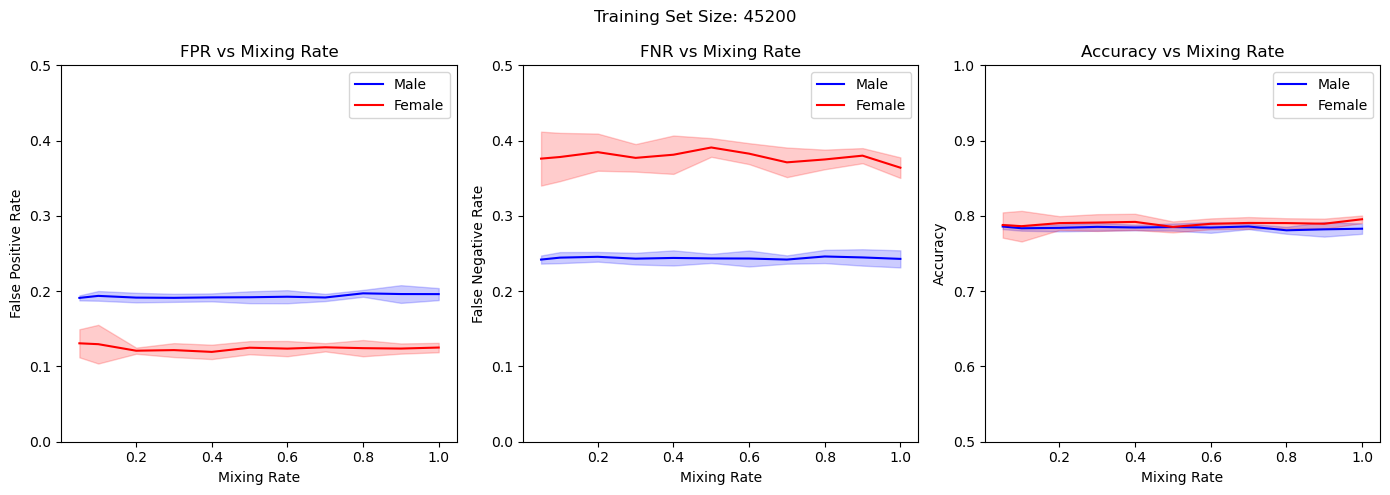

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import folktables
from folktables import ACSDataSource

def fetch_data_for_state(state):
    data_source = ACSDataSource(survey_year='2017', horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True)
    features, label, group = ACSIncomeNew.df_to_numpy(acs_data)
    return features, label, group

def calculate_metrics(y_true, y_pred):
    # Check if the confusion matrix is empty
    if np.sum(y_true == 1) == 0 or np.sum(y_true == 0) == 0:
        fpr, fnr, acc = np.nan, np.nan, np.nan
    else:
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Extract values from the confusion matrix
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        acc = accuracy_score(y_true, y_pred)
    return fpr, fnr, acc

ACSIncomeNew = folktables.BasicProblem(
    features=[
        'AGEP', # Age (1-99)\n",
        'COW', # Class of Worker (1-9)\n",
        'SCHL', # Education (1-24)\n",
        'MAR', # Marital status (1-5)\n",
        'OCCP', # Occupation 0000-9920\n",
        'POBP', # Place of birth 000-554\n",
        'RELP', ## Relationship (00-17)\n",
        'WKHP',# Hours worked per week (0-99)\n",
        'SEX', # sex (1,2)\n",
        'RAC1P', # race (1-9)\n",
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)



# Evaluation function for different mixing rates and modified sizes
def evaluate_model_with_mixing_rate_and_size(mixing_rate, modified_size, features, labels, groups):
    initial_size = len(features)
    num_males_original = np.sum(groups == 1)
    num_females_original = np.sum(groups == 2)

    female_indices = np.where(groups == 2)[0]
    num_female_to_keep = int(len(female_indices) * mixing_rate)
    subsampled_female_indices = np.random.choice(female_indices, size=num_female_to_keep, replace=False)

    modified_features = np.concatenate([features[groups == 1], features[subsampled_female_indices]])
    modified_labels = np.concatenate([labels[groups == 1], labels[subsampled_female_indices]])
    modified_groups = np.concatenate([groups[groups == 1], groups[subsampled_female_indices]])

    if modified_size is not None and modified_size < len(modified_features):
        subsample_indices = np.random.choice(np.arange(len(modified_features)), size=modified_size, replace=False)
        modified_features = modified_features[subsample_indices]
        modified_labels = modified_labels[subsample_indices]
        modified_groups = modified_groups[subsample_indices]

    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        modified_features, modified_labels, modified_groups, test_size=0.2, random_state=0)

    model = make_pipeline(StandardScaler(), LogisticRegression())
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    fpr_male, fnr_male, acc_male = calculate_metrics(y_test[group_test == 1], y_pred[group_test == 1])
    fpr_female, fnr_female, acc_female = calculate_metrics(y_test[group_test == 2], y_pred[group_test == 2])

    return initial_size, modified_size, num_males_original, num_females_original, len(modified_features), \
           fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female

# Fetch data for California
ca_features, ca_label, ca_group = fetch_data_for_state('CA')

# Split data for training
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    ca_features, ca_label, ca_group, test_size=0.3, random_state=0)

# Train the model
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

mixing_rates = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Total females in the dataset
total_females = len(np.where(ca_group == 2)[0])

print("TX 2015 Data")

# Iterate over different fixed training set sizes
fixed_train_sizes = [int(round(0.1 * total_females, -2)), int(round(0.3 * total_females, -2)), int(round(0.5 * total_females, -2))]
for fixed_train_size in fixed_train_sizes:
    print("Fixed training set size: ", fixed_train_size)

    results_subset_list = []
    num_iterations = 10
    for _ in range(num_iterations):
        results_subset = {'Mixing Rate': [], 'FPR Male': [], 'FNR Male': [], 'Accuracy Male': [],
                          'FPR Female': [], 'FNR Female': [], 'Accuracy Female': []}
        for mixing_rate in mixing_rates:
            initial_size, _, num_males_original, num_females_original, _, \
            fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female = \
            evaluate_model_with_mixing_rate_and_size(mixing_rate, fixed_train_size, ca_features, ca_label, ca_group)

            results_subset['Mixing Rate'].append(mixing_rate)
            results_subset['FPR Male'].append(fpr_male)
            results_subset['FNR Male'].append(fnr_male)
            results_subset['Accuracy Male'].append(acc_male)
            results_subset['FPR Female'].append(fpr_female)
            results_subset['FNR Female'].append(fnr_female)
            results_subset['Accuracy Female'].append(acc_female)

        results_subset_list.append(results_subset)

    average_results_subset = {'Mixing Rate': mixing_rates,
                              'FPR Male': np.mean([result['FPR Male'] for result in results_subset_list], axis=0),
                              'FNR Male': np.mean([result['FNR Male'] for result in results_subset_list], axis=0),
                              'Accuracy Male': np.mean([result['Accuracy Male'] for result in results_subset_list], axis=0),
                              'FPR Female': np.mean([result['FPR Female'] for result in results_subset_list], axis=0),
                              'FNR Female': np.mean([result['FNR Female'] for result in results_subset_list], axis=0),
                              'Accuracy Female': np.mean([result['Accuracy Female'] for result in results_subset_list], axis=0)}

    average_results_subset_df = pd.DataFrame(average_results_subset)

    std_results_subset = {'FPR Male': np.std([result['FPR Male'] for result in results_subset_list], axis=0),
                          'FNR Male': np.std([result['FNR Male'] for result in results_subset_list], axis=0),
                          'Accuracy Male': np.std([result['Accuracy Male'] for result in results_subset_list], axis=0),
                          'FPR Female': np.std([result['FPR Female'] for result in results_subset_list], axis=0),
                          'FNR Female': np.std([result['FNR Female'] for result in results_subset_list], axis=0),
                          'Accuracy Female': np.std([result['Accuracy Female'] for result in results_subset_list], axis=0)}
    
    print(f"Original training set size: {len(X_train)}")
    print(f"Original number of females in train set: {np.sum(group_train == 2)}")
    print(f"Percentage of total females that's being currently graphed: {fixed_train_size / total_females * 100}%")


    fig, axs = plt.subplots(1, 3, figsize=(14, 5))
    plt.title('CA 2018: ACSIncome MALE / FEMALE')
    fig.suptitle(f'Training Set Size: {fixed_train_size}')

    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Male'], label='Male', color='blue')
    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Female'], label='Female', color='red')
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Male'] - std_results_subset['FPR Male'],
                       average_results_subset_df['FPR Male'] + std_results_subset['FPR Male'],
                       color='blue', alpha=0.2)
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Female'] - std_results_subset['FPR Female'],
                       average_results_subset_df['FPR Female'] + std_results_subset['FPR Female'],
                       color='red', alpha=0.2)
    axs[0].set_xlabel('Mixing Rate')
    axs[0].set_ylabel('False Positive Rate')
    axs[0].set_title('FPR vs Mixing Rate')
    axs[0].legend()
    axs[0].set_ylim(0, 0.5)

    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Male'], label='Male', color='blue')
    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Female'], label='Female', color='red')
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Male'] - std_results_subset['FNR Male'],
                       average_results_subset_df['FNR Male'] + std_results_subset['FNR Male'],
                       color='blue', alpha=0.2)
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Female'] - std_results_subset['FNR Female'],
                       average_results_subset_df['FNR Female'] + std_results_subset['FNR Female'],
                       color='red', alpha=0.2)
    axs[1].set_xlabel('Mixing Rate')
    axs[1].set_ylabel('False Negative Rate')
    axs[1].set_title('FNR vs Mixing Rate')
    axs[1].legend()
    axs[1].set_ylim(0, 0.5)

    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Male'], label='Male', color='blue')
    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Female'], label='Female', color='red')
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Male'] - std_results_subset['Accuracy Male'],
                       average_results_subset_df['Accuracy Male'] + std_results_subset['Accuracy Male'],
                       color='blue', alpha=0.2)
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Female'] - std_results_subset['Accuracy Female'],
                       average_results_subset_df['Accuracy Female'] + std_results_subset['Accuracy Female'],
                       color='red', alpha=0.2)
    axs[2].set_xlabel('Mixing Rate')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_title('Accuracy vs Mixing Rate')
    axs[2].legend()
    axs[2].set_ylim(0.5, 1.0)

    plt.tight_layout()
    fig.suptitle(f'Training Set Size: {fixed_train_size}')
    plt.show()


TX 2017

TX 2017 Data
Fixed training set size:  9000
Original training set size: 135050
Original number of females in train set: 63200
Percentage of total females that's being currently graphed: 9.956853634251576%


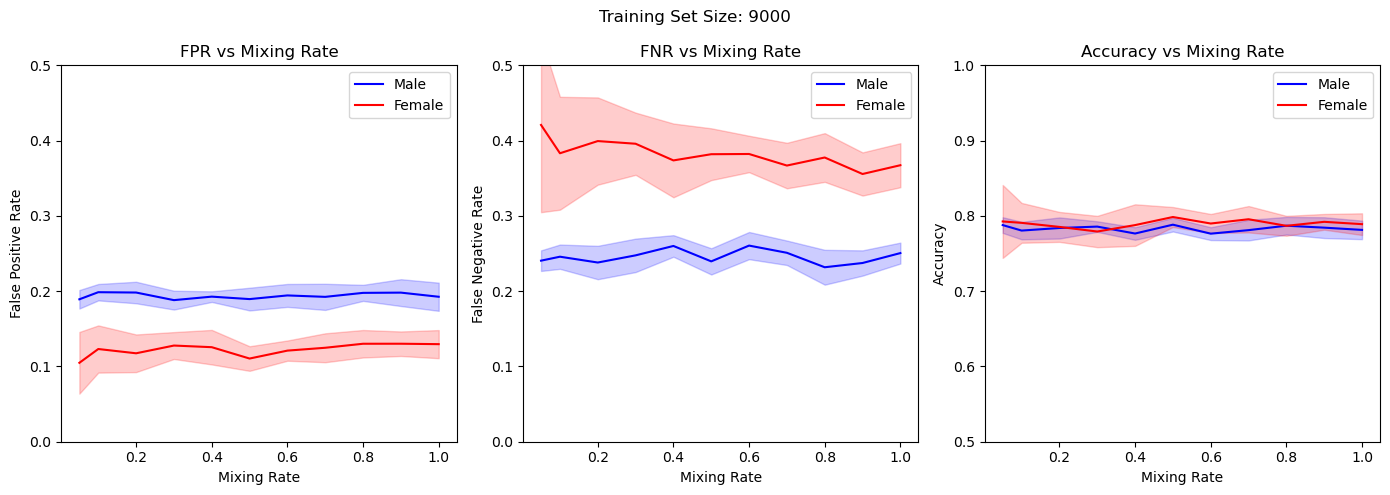

Fixed training set size:  27100
Original training set size: 135050
Original number of females in train set: 63200
Percentage of total females that's being currently graphed: 29.981192609801973%


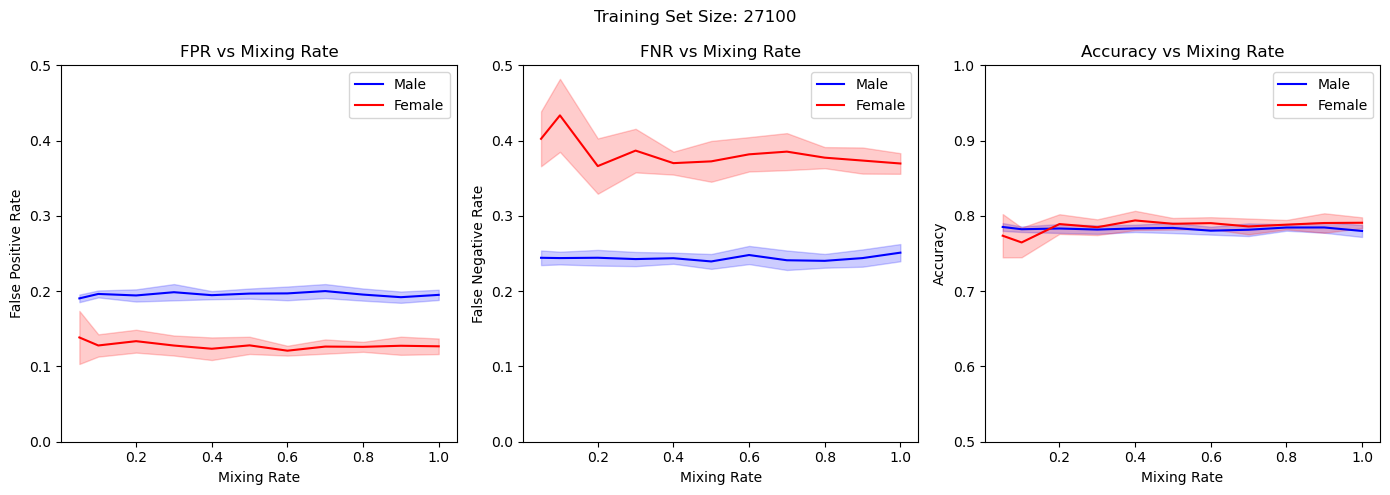

Fixed training set size:  45200
Original training set size: 135050
Original number of females in train set: 63200
Percentage of total females that's being currently graphed: 50.00553158535236%


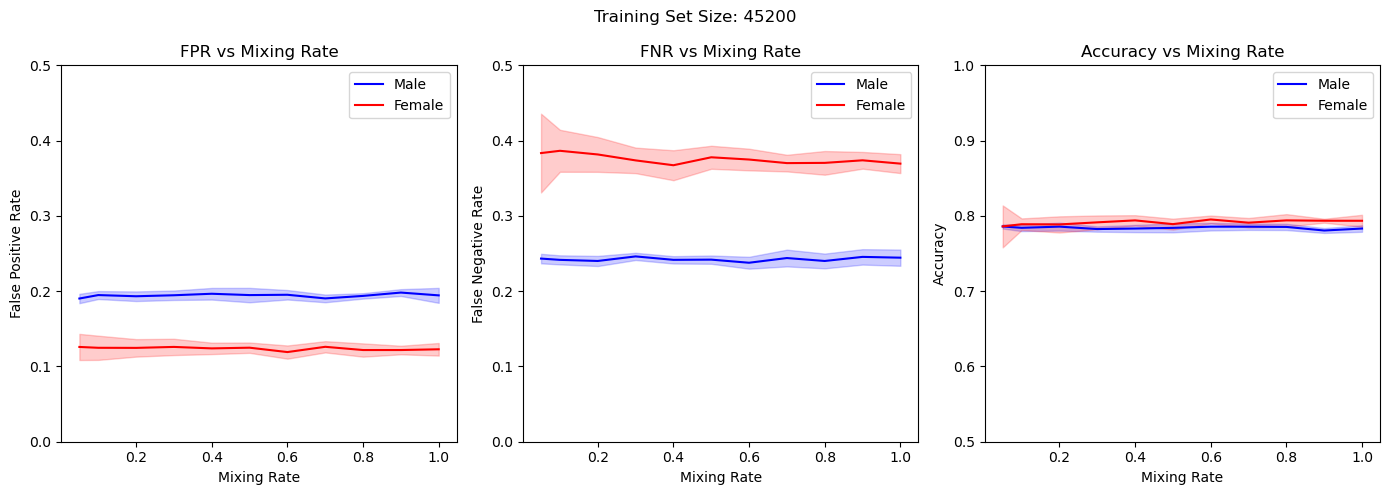

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import folktables
from folktables import ACSDataSource

def fetch_data_for_state(state):
    data_source = ACSDataSource(survey_year='2017', horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True)
    features, label, group = ACSIncomeNew.df_to_numpy(acs_data)
    return features, label, group

def calculate_metrics(y_true, y_pred):
    # Check if the confusion matrix is empty
    if np.sum(y_true == 1) == 0 or np.sum(y_true == 0) == 0:
        fpr, fnr, acc = np.nan, np.nan, np.nan
    else:
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Extract values from the confusion matrix
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        acc = accuracy_score(y_true, y_pred)
    return fpr, fnr, acc

ACSIncomeNew = folktables.BasicProblem(
    features=[
        'AGEP', # Age (1-99)\n",
        'COW', # Class of Worker (1-9)\n",
        'SCHL', # Education (1-24)\n",
        'MAR', # Marital status (1-5)\n",
        'OCCP', # Occupation 0000-9920\n",
        'POBP', # Place of birth 000-554\n",
        'RELP', ## Relationship (00-17)\n",
        'WKHP',# Hours worked per week (0-99)\n",
        'SEX', # sex (1,2)\n",
        'RAC1P', # race (1-9)\n",
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)



# Evaluation function for different mixing rates and modified sizes
def evaluate_model_with_mixing_rate_and_size(mixing_rate, modified_size, features, labels, groups):
    initial_size = len(features)
    num_males_original = np.sum(groups == 1)
    num_females_original = np.sum(groups == 2)

    female_indices = np.where(groups == 2)[0]
    num_female_to_keep = int(len(female_indices) * mixing_rate)
    subsampled_female_indices = np.random.choice(female_indices, size=num_female_to_keep, replace=False)

    modified_features = np.concatenate([features[groups == 1], features[subsampled_female_indices]])
    modified_labels = np.concatenate([labels[groups == 1], labels[subsampled_female_indices]])
    modified_groups = np.concatenate([groups[groups == 1], groups[subsampled_female_indices]])

    if modified_size is not None and modified_size < len(modified_features):
        subsample_indices = np.random.choice(np.arange(len(modified_features)), size=modified_size, replace=False)
        modified_features = modified_features[subsample_indices]
        modified_labels = modified_labels[subsample_indices]
        modified_groups = modified_groups[subsample_indices]

    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        modified_features, modified_labels, modified_groups, test_size=0.2, random_state=0)

    model = make_pipeline(StandardScaler(), LogisticRegression())
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    fpr_male, fnr_male, acc_male = calculate_metrics(y_test[group_test == 1], y_pred[group_test == 1])
    fpr_female, fnr_female, acc_female = calculate_metrics(y_test[group_test == 2], y_pred[group_test == 2])

    return initial_size, modified_size, num_males_original, num_females_original, len(modified_features), \
           fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female

# Fetch data for California
ca_features, ca_label, ca_group = fetch_data_for_state('CA')

# Split data for training
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    ca_features, ca_label, ca_group, test_size=0.3, random_state=0)

# Train the model
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

mixing_rates = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Total females in the dataset
total_females = len(np.where(ca_group == 2)[0])

print("TX 2017 Data")

# Iterate over different fixed training set sizes
fixed_train_sizes = [int(round(0.1 * total_females, -2)), int(round(0.3 * total_females, -2)), int(round(0.5 * total_females, -2))]
for fixed_train_size in fixed_train_sizes:
    print("Fixed training set size: ", fixed_train_size)

    results_subset_list = []
    num_iterations = 10
    for _ in range(num_iterations):
        results_subset = {'Mixing Rate': [], 'FPR Male': [], 'FNR Male': [], 'Accuracy Male': [],
                          'FPR Female': [], 'FNR Female': [], 'Accuracy Female': []}
        for mixing_rate in mixing_rates:
            initial_size, _, num_males_original, num_females_original, _, \
            fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female = \
            evaluate_model_with_mixing_rate_and_size(mixing_rate, fixed_train_size, ca_features, ca_label, ca_group)

            results_subset['Mixing Rate'].append(mixing_rate)
            results_subset['FPR Male'].append(fpr_male)
            results_subset['FNR Male'].append(fnr_male)
            results_subset['Accuracy Male'].append(acc_male)
            results_subset['FPR Female'].append(fpr_female)
            results_subset['FNR Female'].append(fnr_female)
            results_subset['Accuracy Female'].append(acc_female)

        results_subset_list.append(results_subset)

    average_results_subset = {'Mixing Rate': mixing_rates,
                              'FPR Male': np.mean([result['FPR Male'] for result in results_subset_list], axis=0),
                              'FNR Male': np.mean([result['FNR Male'] for result in results_subset_list], axis=0),
                              'Accuracy Male': np.mean([result['Accuracy Male'] for result in results_subset_list], axis=0),
                              'FPR Female': np.mean([result['FPR Female'] for result in results_subset_list], axis=0),
                              'FNR Female': np.mean([result['FNR Female'] for result in results_subset_list], axis=0),
                              'Accuracy Female': np.mean([result['Accuracy Female'] for result in results_subset_list], axis=0)}

    average_results_subset_df = pd.DataFrame(average_results_subset)

    std_results_subset = {'FPR Male': np.std([result['FPR Male'] for result in results_subset_list], axis=0),
                          'FNR Male': np.std([result['FNR Male'] for result in results_subset_list], axis=0),
                          'Accuracy Male': np.std([result['Accuracy Male'] for result in results_subset_list], axis=0),
                          'FPR Female': np.std([result['FPR Female'] for result in results_subset_list], axis=0),
                          'FNR Female': np.std([result['FNR Female'] for result in results_subset_list], axis=0),
                          'Accuracy Female': np.std([result['Accuracy Female'] for result in results_subset_list], axis=0)}
    
    print(f"Original training set size: {len(X_train)}")
    print(f"Original number of females in train set: {np.sum(group_train == 2)}")
    print(f"Percentage of total females that's being currently graphed: {fixed_train_size / total_females * 100}%")


    fig, axs = plt.subplots(1, 3, figsize=(14, 5))
    plt.title('CA 2018: ACSIncome MALE / FEMALE')
    fig.suptitle(f'Training Set Size: {fixed_train_size}')

    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Male'], label='Male', color='blue')
    axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Female'], label='Female', color='red')
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Male'] - std_results_subset['FPR Male'],
                       average_results_subset_df['FPR Male'] + std_results_subset['FPR Male'],
                       color='blue', alpha=0.2)
    axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FPR Female'] - std_results_subset['FPR Female'],
                       average_results_subset_df['FPR Female'] + std_results_subset['FPR Female'],
                       color='red', alpha=0.2)
    axs[0].set_xlabel('Mixing Rate')
    axs[0].set_ylabel('False Positive Rate')
    axs[0].set_title('FPR vs Mixing Rate')
    axs[0].legend()
    axs[0].set_ylim(0, 0.5)

    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Male'], label='Male', color='blue')
    axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Female'], label='Female', color='red')
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Male'] - std_results_subset['FNR Male'],
                       average_results_subset_df['FNR Male'] + std_results_subset['FNR Male'],
                       color='blue', alpha=0.2)
    axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['FNR Female'] - std_results_subset['FNR Female'],
                       average_results_subset_df['FNR Female'] + std_results_subset['FNR Female'],
                       color='red', alpha=0.2)
    axs[1].set_xlabel('Mixing Rate')
    axs[1].set_ylabel('False Negative Rate')
    axs[1].set_title('FNR vs Mixing Rate')
    axs[1].legend()
    axs[1].set_ylim(0, 0.5)

    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Male'], label='Male', color='blue')
    axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Female'], label='Female', color='red')
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Male'] - std_results_subset['Accuracy Male'],
                       average_results_subset_df['Accuracy Male'] + std_results_subset['Accuracy Male'],
                       color='blue', alpha=0.2)
    axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                       average_results_subset_df['Accuracy Female'] - std_results_subset['Accuracy Female'],
                       average_results_subset_df['Accuracy Female'] + std_results_subset['Accuracy Female'],
                       color='red', alpha=0.2)
    axs[2].set_xlabel('Mixing Rate')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_title('Accuracy vs Mixing Rate')
    axs[2].legend()
    axs[2].set_ylim(0.5, 1.0)

    plt.tight_layout()
    fig.suptitle(f'Training Set Size: {fixed_train_size}')
    plt.show()


In [72]:
results_df

,Mixing Rate,Modified Size,FPR Male,FNR Male,Accuracy Male,FPR Female,FNR Female,Accuracy Female
0,0.05,500,0.283019,0.357143,0.684211,0.000000,0.500000,0.800000
1,0.05,1000,0.226415,0.206897,0.782383,0.333333,0.250000,0.714286
2,0.05,2000,0.229730,0.234568,0.768229,0.272727,0.400000,0.687500
3,0.05,4000,0.172986,0.216138,0.807542,0.227273,0.333333,0.741935
4,0.05,8000,0.204651,0.254844,0.773351,0.186047,0.269231,0.782609
...,...,...,...,...,...,...,...,...
61,1.00,1000,0.210526,0.275862,0.767442,0.131579,0.289474,0.815789
62,1.00,2000,0.252101,0.285714,0.732143,0.228070,0.387097,0.715909
63,1.00,4000,0.200957,0.202970,0.798054,0.108434,0.350000,0.804627
64,1.00,8000,0.167401,0.247396,0.795943,0.135397,0.330612,0.801837


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import folktables
from folktables import ACSDataSource

def fetch_data_for_state(state):
    data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True)
    features, label, group = ACSIncomeNew.df_to_numpy(acs_data)
    return features, label, group

def calculate_metrics(y_true, y_pred):
    # Check if the confusion matrix is empty
    if np.sum(y_true == 1) == 0 or np.sum(y_true == 0) == 0:
        fpr, fnr, acc = np.nan, np.nan, np.nan
    else:
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Extract values from the confusion matrix
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        acc = accuracy_score(y_true, y_pred)
    return fpr, fnr, acc

ACSEmployment = folktables.BasicProblem(
    features=[
        'AGEP',
        'SCHL',
        'MAR',
        'RELP',
        'DIS',
        'ESP',
        'CIT',
        'MIG',
        'MIL',
        'ANC',
        'NATIVITY',
        'DEAR',
        'DEYE',
        'DREM',
        'SEX',
        'RAC1P',
    ],
    target='ESR',
    target_transform=lambda x: x == 1,
    group='SEX',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)


def evaluate_model_with_mixing_rate_and_size(mixing_rate, modified_size, features, labels, groups):
    # Calculate the initial size of the dataset
#     initial_size = len(features)
#     print("Initial size", initial_size)
#     num_males_original = np.sum(groups == 1)
#     print("Number of Males Original", num_males_original)
#     num_females_original = np.sum(groups == 2)
#     print("Number of Females Original", num_females_original)


    # Adjust the mixing rate by subsampling the 'female' group
    female_indices = np.where(groups == 2)[0]
    num_female_to_keep = int(len(female_indices) * mixing_rate)
    subsampled_female_indices = np.random.choice(female_indices, size=num_female_to_keep, replace=False)

    # Create the modified dataset
    modified_features = np.concatenate([features[groups == 1], features[subsampled_female_indices]])
    modified_labels = np.concatenate([labels[groups == 1], labels[subsampled_female_indices]])
    modified_groups = np.concatenate([groups[groups == 1], groups[subsampled_female_indices]])

    # If the modified size is specified, subsample to the desired size
    if modified_size is not None and modified_size < len(modified_features):
        subsample_indices = np.random.choice(np.arange(len(modified_features)), size=modified_size, replace=False)
        modified_features = modified_features[subsample_indices]
        modified_labels = modified_labels[subsample_indices]
        modified_groups = modified_groups[subsample_indices]

    # Split the modified dataset into train and test sets
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        modified_features, modified_labels, modified_groups, test_size=0.2, random_state=0)

    # Create and fit the model
    model = make_pipeline(StandardScaler(), LogisticRegression())
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate FPR, FNR, and Accuracy for male (group = 1) and female (group = 2)
    fpr_male, fnr_male, acc_male = calculate_metrics(y_test[group_test == 1], y_pred[group_test == 1])
    fpr_female, fnr_female, acc_female = calculate_metrics(y_test[group_test == 2], y_pred[group_test == 2])

    return initial_size, modified_size, num_males_original, num_females_original, len(modified_features), \
           fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_ca = data_source.get_data(states=["CA"], download=True)
ca_features, ca_label, ca_group = ACSEmployment.df_to_numpy(acs_ca)

# Split data for training
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    ca_features, ca_label, ca_group, test_size=0.3, random_state=0)

# Train the model
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

mixing_rates = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# modified_sizes = [4000, 8000, 10000]

totalFemales = len(np.where(ca_group == 2)[0])
print("total Females in dataset: ", totalFemales)

# fix training set size to 0.5 * Females, round to nearest multiple of 100
fixed_train_size = int(round(0.5 * totalFemales, -2))
print("fixed training set size: ", fixed_train_size)



# fixed_train_set_size = 0.5 * num_females_original

results = {'Mixing Rate': [], 'Initial Size': [], 'Modified Size': [], 'Num Males Original': [],
           'Num Females Original': [], 'FPR Male': [], 'FNR Male': [], 'Accuracy Male': [],
           'FPR Female': [], 'FNR Female': [], 'Accuracy Female': []}

# Separate graphs for FPR, FNR, and Accuracy for each training set size
# for modified_size in modified_sizes:# ... (previous code)

# Separate graphs for FPR, FNR, and Accuracy for each training set size
# for modified_size in modified_sizes:
results_subset_list = []  # List to store results of each iteration
num_iterations = 5
for _ in range(num_iterations):  # Set the number of iterations
    results_subset = {'Mixing Rate': [], 'FPR Male': [], 'FNR Male': [], 'Accuracy Male': [],
                      'FPR Female': [], 'FNR Female': [], 'Accuracy Female': []}
    for mixing_rate in mixing_rates:
        initial_size, _, num_males_original, num_females_original, _, \
        fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female = \
        evaluate_model_with_mixing_rate_and_size(mixing_rate, fixed_train_size, ca_features, ca_label, ca_group)

        results_subset['Mixing Rate'].append(mixing_rate)
        results_subset['FPR Male'].append(fpr_male)
        results_subset['FNR Male'].append(fnr_male)
        results_subset['Accuracy Male'].append(acc_male)
        results_subset['FPR Female'].append(fpr_female)
        results_subset['FNR Female'].append(fnr_female)
        results_subset['Accuracy Female'].append(acc_female)

    results_subset_list.append(results_subset)

# Calculate the average values across iterations
average_results_subset = {'Mixing Rate': mixing_rates,
                          'FPR Male': np.mean([result['FPR Male'] for result in results_subset_list], axis=0),
                          'FNR Male': np.mean([result['FNR Male'] for result in results_subset_list], axis=0),
                          'Accuracy Male': np.mean([result['Accuracy Male'] for result in results_subset_list], axis=0),
                          'FPR Female': np.mean([result['FPR Female'] for result in results_subset_list], axis=0),
                          'FNR Female': np.mean([result['FNR Female'] for result in results_subset_list], axis=0),
                          'Accuracy Female': np.mean([result['Accuracy Female'] for result in results_subset_list], axis=0)}

average_results_subset_df = pd.DataFrame(average_results_subset)

# Calculate standard deviation across iterations
std_results_subset = {'FPR Male': np.std([result['FPR Male'] for result in results_subset_list], axis=0),
                      'FNR Male': np.std([result['FNR Male'] for result in results_subset_list], axis=0),
                      'Accuracy Male': np.std([result['Accuracy Male'] for result in results_subset_list], axis=0),
                      'FPR Female': np.std([result['FPR Female'] for result in results_subset_list], axis=0),
                      'FNR Female': np.std([result['FNR Female'] for result in results_subset_list], axis=0),
                      'Accuracy Female': np.std([result['Accuracy Female'] for result in results_subset_list], axis=0)}

# Plotting for FPR, FNR, and Accuracy with shaded regions
fig, axs = plt.subplots(1, 3, figsize=(14, 5))  # Use 1 row and 3 columns
fig.suptitle(f'Training Set Size: {fixed_train_size}')

# Plot FPR for Male and Female with shaded region for standard deviation
axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Male'], label='Male', color='blue')
axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Female'], label='Female', color='red')
axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['FPR Male'] - std_results_subset['FPR Male'],
                   average_results_subset_df['FPR Male'] + std_results_subset['FPR Male'],
                   color='blue', alpha=0.2)
axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['FPR Female'] - std_results_subset['FPR Female'],
                   average_results_subset_df['FPR Female'] + std_results_subset['FPR Female'],
                   color='red', alpha=0.2)
axs[0].set_xlabel('Mixing Rate')
axs[0].set_ylabel('False Positive Rate')
axs[0].set_title('FPR vs Mixing Rate')
axs[0].legend()
axs[0].set_ylim(0, 0.5)

# Plot FNR for Male and Female with shaded region for standard deviation
axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Male'], label='Male', color='blue')
axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Female'], label='Female', color='red')
axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['FNR Male'] - std_results_subset['FNR Male'],
                   average_results_subset_df['FNR Male'] + std_results_subset['FNR Male'],
                   color='blue', alpha=0.2)
axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['FNR Female'] - std_results_subset['FNR Female'],
                   average_results_subset_df['FNR Female'] + std_results_subset['FNR Female'],
                   color='red', alpha=0.2)
axs[1].set_xlabel('Mixing Rate')
axs[1].set_ylabel('False Negative Rate')
axs[1].set_title('FNR vs Mixing Rate')
axs[1].legend()
axs[1].set_ylim(0, 0.5)

# Plot Accuracy for Male and Female with shaded region for standard deviation
axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Male'], label='Male', color='blue')
axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Female'], label='Female', color='red')
axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['Accuracy Male'] - std_results_subset['Accuracy Male'],
                   average_results_subset_df['Accuracy Male'] + std_results_subset['Accuracy Male'],
                   color='blue', alpha=0.2)
axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['Accuracy Female'] - std_results_subset['Accuracy Female'],
                   average_results_subset_df['Accuracy Female'] + std_results_subset['Accuracy Female'],
                   color='red', alpha=0.2)
axs[2].set_xlabel('Mixing Rate')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Accuracy vs Mixing Rate')
axs[2].legend()
axs[2].set_ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

total Females in dataset:  192140
fixed training set size:  96100


NameError: name 'initial_size' is not defined

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import folktables
from folktables import ACSDataSource

def fetch_data_for_state(state):
    data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True)
    features, label, group = ACSIncomeNew.df_to_numpy(acs_data)
    return features, label, group

def calculate_metrics(y_true, y_pred):
    # Check if the confusion matrix is empty
    if np.sum(y_true == 1) == 0 or np.sum(y_true == 0) == 0:
        fpr, fnr, acc = np.nan, np.nan, np.nan
    else:
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Extract values from the confusion matrix
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        acc = accuracy_score(y_true, y_pred)
    return fpr, fnr, acc

ACSEmployment = folktables.BasicProblem(
    features=[
        'AGEP',
        'SCHL',
        'MAR',
        'RELP',
        'DIS',
        'ESP',
        'CIT',
        'MIG',
        'MIL',
        'ANC',
        'NATIVITY',
        'DEAR',
        'DEYE',
        'DREM',
        'SEX',
        'RAC1P',
    ],
    target='ESR',
    target_transform=lambda x: x == 1,
    group='SEX',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)


def evaluate_model_with_mixing_rate_and_size(mixing_rate, modified_size, features, labels, groups):
    # Calculate the initial size of the dataset
#     initial_size = len(features)
#     print("Initial size", initial_size)
#     num_males_original = np.sum(groups == 1)
#     print("Number of Males Original", num_males_original)
#     num_females_original = np.sum(groups == 2)
#     print("Number of Females Original", num_females_original)


    # Adjust the mixing rate by subsampling the 'female' group
    female_indices = np.where(groups == 2)[0]
    num_female_to_keep = int(len(female_indices) * mixing_rate)
    subsampled_female_indices = np.random.choice(female_indices, size=num_female_to_keep, replace=False)

    # Create the modified dataset
    modified_features = np.concatenate([features[groups == 1], features[subsampled_female_indices]])
    modified_labels = np.concatenate([labels[groups == 1], labels[subsampled_female_indices]])
    modified_groups = np.concatenate([groups[groups == 1], groups[subsampled_female_indices]])

    # If the modified size is specified, subsample to the desired size
    if modified_size is not None and modified_size < len(modified_features):
        subsample_indices = np.random.choice(np.arange(len(modified_features)), size=modified_size, replace=False)
        modified_features = modified_features[subsample_indices]
        modified_labels = modified_labels[subsample_indices]
        modified_groups = modified_groups[subsample_indices]

    # Split the modified dataset into train and test sets
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        modified_features, modified_labels, modified_groups, test_size=0.2, random_state=0)

    # Create and fit the model
    model = make_pipeline(StandardScaler(), LogisticRegression())
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate FPR, FNR, and Accuracy for male (group = 1) and female (group = 2)
    fpr_male, fnr_male, acc_male = calculate_metrics(y_test[group_test == 1], y_pred[group_test == 1])
    fpr_female, fnr_female, acc_female = calculate_metrics(y_test[group_test == 2], y_pred[group_test == 2])

    return initial_size, modified_size, num_males_original, num_females_original, len(modified_features), \
           fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_ca = data_source.get_data(states=["CA"], download=True)
ca_features, ca_label, ca_group = ACSEmployment.df_to_numpy(acs_ca)

# Split data for training
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    ca_features, ca_label, ca_group, test_size=0.3, random_state=0)

# Train the model
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

mixing_rates = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# modified_sizes = [4000, 8000, 10000]

totalFemales = len(np.where(ca_group == 2)[0])
print("total Females in dataset: ", totalFemales)

# fix training set size to 0.5 * Females, round to nearest multiple of 100
fixed_train_size = int(round(0.25 * totalFemales, -2))
print("fixed training set size: ", fixed_train_size)



# fixed_train_set_size = 0.5 * num_females_original

results = {'Mixing Rate': [], 'Initial Size': [], 'Modified Size': [], 'Num Males Original': [],
           'Num Females Original': [], 'FPR Male': [], 'FNR Male': [], 'Accuracy Male': [],
           'FPR Female': [], 'FNR Female': [], 'Accuracy Female': []}

# Separate graphs for FPR, FNR, and Accuracy for each training set size
# for modified_size in modified_sizes:# ... (previous code)

# Separate graphs for FPR, FNR, and Accuracy for each training set size
# for modified_size in modified_sizes:
results_subset_list = []  # List to store results of each iteration
num_iterations = 5
for _ in range(num_iterations):  # Set the number of iterations
    results_subset = {'Mixing Rate': [], 'FPR Male': [], 'FNR Male': [], 'Accuracy Male': [],
                      'FPR Female': [], 'FNR Female': [], 'Accuracy Female': []}
    for mixing_rate in mixing_rates:
        initial_size, _, num_males_original, num_females_original, _, \
        fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female = \
        evaluate_model_with_mixing_rate_and_size(mixing_rate, fixed_train_size, ca_features, ca_label, ca_group)

        results_subset['Mixing Rate'].append(mixing_rate)
        results_subset['FPR Male'].append(fpr_male)
        results_subset['FNR Male'].append(fnr_male)
        results_subset['Accuracy Male'].append(acc_male)
        results_subset['FPR Female'].append(fpr_female)
        results_subset['FNR Female'].append(fnr_female)
        results_subset['Accuracy Female'].append(acc_female)

    results_subset_list.append(results_subset)

# Calculate the average values across iterations
average_results_subset = {'Mixing Rate': mixing_rates,
                          'FPR Male': np.mean([result['FPR Male'] for result in results_subset_list], axis=0),
                          'FNR Male': np.mean([result['FNR Male'] for result in results_subset_list], axis=0),
                          'Accuracy Male': np.mean([result['Accuracy Male'] for result in results_subset_list], axis=0),
                          'FPR Female': np.mean([result['FPR Female'] for result in results_subset_list], axis=0),
                          'FNR Female': np.mean([result['FNR Female'] for result in results_subset_list], axis=0),
                          'Accuracy Female': np.mean([result['Accuracy Female'] for result in results_subset_list], axis=0)}

average_results_subset_df = pd.DataFrame(average_results_subset)

# Calculate standard deviation across iterations
std_results_subset = {'FPR Male': np.std([result['FPR Male'] for result in results_subset_list], axis=0),
                      'FNR Male': np.std([result['FNR Male'] for result in results_subset_list], axis=0),
                      'Accuracy Male': np.std([result['Accuracy Male'] for result in results_subset_list], axis=0),
                      'FPR Female': np.std([result['FPR Female'] for result in results_subset_list], axis=0),
                      'FNR Female': np.std([result['FNR Female'] for result in results_subset_list], axis=0),
                      'Accuracy Female': np.std([result['Accuracy Female'] for result in results_subset_list], axis=0)}

# Plotting for FPR, FNR, and Accuracy with shaded regions
fig, axs = plt.subplots(1, 3, figsize=(14, 5))  # Use 1 row and 3 columns
fig.suptitle(f'Training Set Size: {fixed_train_size}')

# Plot FPR for Male and Female with shaded region for standard deviation
axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Male'], label='Male', color='blue')
axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Female'], label='Female', color='red')
axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['FPR Male'] - std_results_subset['FPR Male'],
                   average_results_subset_df['FPR Male'] + std_results_subset['FPR Male'],
                   color='blue', alpha=0.2)
axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['FPR Female'] - std_results_subset['FPR Female'],
                   average_results_subset_df['FPR Female'] + std_results_subset['FPR Female'],
                   color='red', alpha=0.2)
axs[0].set_xlabel('Mixing Rate')
axs[0].set_ylabel('False Positive Rate')
axs[0].set_title('FPR vs Mixing Rate')
axs[0].legend()
axs[0].set_ylim(0, 0.5)

# Plot FNR for Male and Female with shaded region for standard deviation
axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Male'], label='Male', color='blue')
axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Female'], label='Female', color='red')
axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['FNR Male'] - std_results_subset['FNR Male'],
                   average_results_subset_df['FNR Male'] + std_results_subset['FNR Male'],
                   color='blue', alpha=0.2)
axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['FNR Female'] - std_results_subset['FNR Female'],
                   average_results_subset_df['FNR Female'] + std_results_subset['FNR Female'],
                   color='red', alpha=0.2)
axs[1].set_xlabel('Mixing Rate')
axs[1].set_ylabel('False Negative Rate')
axs[1].set_title('FNR vs Mixing Rate')
axs[1].legend()
axs[1].set_ylim(0, 0.5)

# Plot Accuracy for Male and Female with shaded region for standard deviation
axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Male'], label='Male', color='blue')
axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Female'], label='Female', color='red')
axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['Accuracy Male'] - std_results_subset['Accuracy Male'],
                   average_results_subset_df['Accuracy Male'] + std_results_subset['Accuracy Male'],
                   color='blue', alpha=0.2)
axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['Accuracy Female'] - std_results_subset['Accuracy Female'],
                   average_results_subset_df['Accuracy Female'] + std_results_subset['Accuracy Female'],
                   color='red', alpha=0.2)
axs[2].set_xlabel('Mixing Rate')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Accuracy vs Mixing Rate')
axs[2].legend()
axs[2].set_ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

total Females in dataset:  192140
fixed training set size:  96100


NameError: name 'initial_size' is not defined